<a href="https://colab.research.google.com/github/DhinekkaB/AI-Face-Detection-using-ATSAMA5D27-WLSOM-EK1/blob/main/CCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
zip_path = "/content/drive/MyDrive/ck.zip"
extract_path = "/content/newdataset"

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Data Preprocessing for FER Dataset
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FER2013 Dataset
dataset_path = "/content/dataset"  # Change to dataset path
train_data = datasets.ImageFolder(root=dataset_path + "/train", transform=transform)
test_data = datasets.ImageFolder(root=dataset_path + "/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Define CNN Model with Residual Blocks
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.layer1 = ResidualBlock(1, 32)
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.layer3 = ResidualBlock(64, 128, stride=2)
        self.layer4 = ResidualBlock(128, 256, stride=2)
        self.fc = nn.Linear(256 * 6 * 6, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

# Initialize Model
model = EmotionCNN(num_classes=len(train_data.classes)).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    print("Training Complete!")
    torch.save(model.state_dict(), "fer_cnn_model.pth")
    print("Model Saved!")

# Model Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Run Training and Evaluation
train_model(model, train_loader, criterion, optimizer, epochs=20)
evaluate_model(model, test_loader)


Epoch [1/20], Loss: 1.6608
Epoch [2/20], Loss: 1.3116
Epoch [3/20], Loss: 1.1510
Epoch [4/20], Loss: 1.0175
Epoch [5/20], Loss: 0.8733
Epoch [6/20], Loss: 0.6980
Epoch [7/20], Loss: 0.5192
Epoch [8/20], Loss: 0.3274
Epoch [9/20], Loss: 0.2148
Epoch [10/20], Loss: 0.1545
Epoch [11/20], Loss: 0.1229
Epoch [12/20], Loss: 0.1061
Epoch [13/20], Loss: 0.0992
Epoch [14/20], Loss: 0.0889
Epoch [15/20], Loss: 0.0941
Epoch [16/20], Loss: 0.0963
Epoch [17/20], Loss: 0.0934
Epoch [18/20], Loss: 0.0733
Epoch [19/20], Loss: 0.0760
Epoch [20/20], Loss: 0.0698
Training Complete!
Model Saved!
Test Accuracy: 56.31%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Data Preprocessing for FER Dataset
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images randomly
    transforms.RandomRotation(10),  # Rotate images randomly
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness & contrast
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FER2013 Dataset
dataset_path = "/content/dataset"  # Change to dataset path
train_data = datasets.ImageFolder(root=dataset_path + "/train", transform=transform)
test_data = datasets.ImageFolder(root=dataset_path + "/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Define CNN Model with Residual Blocks
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.layer1 = ResidualBlock(1, 32)
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.layer3 = ResidualBlock(64, 128, stride=2)
        self.layer4 = ResidualBlock(128, 256, stride=2)
        self.dropout = nn.Dropout(0.5)  # Add dropout to prevent overfitting
        self.fc = nn.Linear(256 * 6 * 6, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)  # Apply dropout before the final layer
        x = self.fc(x)
        return x

# Initialize Model
model = EmotionCNN(num_classes=len(train_data.classes)).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=30):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    print("Training Complete!")
    torch.save(model.state_dict(), "new_cnn_model.pth")
    print("Model Saved!")

# Model Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Run Training and Evaluation
train_model(model, train_loader, criterion, optimizer, epochs=30)
evaluate_model(model, test_loader)


Epoch [1/30], Loss: 1.7414
Epoch [2/30], Loss: 1.4768
Epoch [3/30], Loss: 1.3475
Epoch [4/30], Loss: 1.2695
Epoch [5/30], Loss: 1.2246
Epoch [6/30], Loss: 1.1822
Epoch [7/30], Loss: 1.1455
Epoch [8/30], Loss: 1.1156
Epoch [9/30], Loss: 1.0808
Epoch [10/30], Loss: 1.0532
Epoch [11/30], Loss: 1.0264
Epoch [12/30], Loss: 1.0022
Epoch [13/30], Loss: 0.9857
Epoch [14/30], Loss: 0.9590
Epoch [15/30], Loss: 0.9369
Epoch [16/30], Loss: 0.9120
Epoch [17/30], Loss: 0.8980
Epoch [18/30], Loss: 0.8780
Epoch [19/30], Loss: 0.8625
Epoch [20/30], Loss: 0.8388
Epoch [21/30], Loss: 0.8210
Epoch [22/30], Loss: 0.8081
Epoch [23/30], Loss: 0.7926
Epoch [24/30], Loss: 0.7691
Epoch [25/30], Loss: 0.7471
Epoch [26/30], Loss: 0.7319
Epoch [27/30], Loss: 0.7221
Epoch [28/30], Loss: 0.7033
Epoch [29/30], Loss: 0.6861
Epoch [30/30], Loss: 0.6682
Training Complete!
Model Saved!
Test Accuracy: 63.05%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Data Preprocessing for FER Dataset
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images randomly
    transforms.RandomRotation(10),  # Rotate images randomly
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness & contrast
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FER2013 Dataset
dataset_path = "/content/dataset"  # Change to dataset path
train_data = datasets.ImageFolder(root=dataset_path + "/train", transform=transform)
test_data = datasets.ImageFolder(root=dataset_path + "/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Define CNN Model with Residual Blocks
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        self.layer1 = ResidualBlock(1, 32)
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.layer3 = ResidualBlock(64, 128, stride=2)
        self.layer4 = ResidualBlock(128, 256, stride=2)
        self.dropout = nn.Dropout(0.6)  # Increase dropout to reduce overfitting
        self.fc = nn.Linear(256 * 6 * 6, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)  # Apply dropout before the final layer
        x = self.fc(x)
        return x

# Initialize Model
model = EmotionCNN(num_classes=len(train_data.classes)).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Adjust learning rate dynamically

# Training Loop
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=50):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()  # Update learning rate
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    print("Training Complete!")
    torch.save(model.state_dict(), "new2_cnn_model.pth")
    print("Model Saved!")

# Model Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Run Training and Evaluation
train_model(model, train_loader, criterion, optimizer, scheduler, epochs=50)
evaluate_model(model, test_loader)


Epoch [1/50], Loss: 1.7635
Epoch [2/50], Loss: 1.5108
Epoch [3/50], Loss: 1.3820
Epoch [4/50], Loss: 1.3005
Epoch [5/50], Loss: 1.2463
Epoch [6/50], Loss: 1.2063
Epoch [7/50], Loss: 1.1722
Epoch [8/50], Loss: 1.1439
Epoch [9/50], Loss: 1.1188
Epoch [10/50], Loss: 1.0955
Epoch [11/50], Loss: 1.0285
Epoch [12/50], Loss: 1.0060
Epoch [13/50], Loss: 0.9820
Epoch [14/50], Loss: 0.9645
Epoch [15/50], Loss: 0.9483
Epoch [16/50], Loss: 0.9320
Epoch [17/50], Loss: 0.9152
Epoch [18/50], Loss: 0.9038
Epoch [19/50], Loss: 0.8863
Epoch [20/50], Loss: 0.8784
Epoch [21/50], Loss: 0.8306
Epoch [22/50], Loss: 0.8159
Epoch [23/50], Loss: 0.8026
Epoch [24/50], Loss: 0.7840
Epoch [25/50], Loss: 0.7752
Epoch [26/50], Loss: 0.7641
Epoch [27/50], Loss: 0.7560
Epoch [28/50], Loss: 0.7453
Epoch [29/50], Loss: 0.7350
Epoch [30/50], Loss: 0.7247
Epoch [31/50], Loss: 0.6999
Epoch [32/50], Loss: 0.6827
Epoch [33/50], Loss: 0.6796
Epoch [34/50], Loss: 0.6791
Epoch [35/50], Loss: 0.6620
Epoch [36/50], Loss: 0.6543
E

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Data Preprocessing for FER Dataset
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images randomly
    transforms.RandomRotation(10),  # Rotate images randomly
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness & contrast
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FER2013 Dataset
dataset_path = "/content/dataset"  # Change to dataset path
train_data = datasets.ImageFolder(root=dataset_path + "/train", transform=transform)
test_data = datasets.ImageFolder(root=dataset_path + "/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define Emotion Recognition Model using ResNet18
class EmotionResNet(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionResNet, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjust for grayscale
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # Adjust output layer

    def forward(self, x):
        return self.resnet(x)

# Initialize Model
model = EmotionResNet(num_classes=len(train_data.classes)).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=75)  # Cosine Annealing LR Scheduler

# Training Loop
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=75):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()  # Update learning rate
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

    print("Training Complete!")
    torch.save(model.state_dict(), "new3_resnet_model.pth")
    print("Model Saved!")

# Model Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Run Training and Evaluation
train_model(model, train_loader, criterion, optimizer, scheduler, epochs=75)
evaluate_model(model, test_loader)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


Epoch [1/75], Loss: 1.4061
Epoch [2/75], Loss: 1.1427
Epoch [3/75], Loss: 1.0480
Epoch [4/75], Loss: 0.9811
Epoch [5/75], Loss: 0.9207
Epoch [6/75], Loss: 0.8647
Epoch [7/75], Loss: 0.8137
Epoch [8/75], Loss: 0.7559
Epoch [9/75], Loss: 0.7013
Epoch [10/75], Loss: 0.6425
Epoch [11/75], Loss: 0.5897
Epoch [12/75], Loss: 0.5363
Epoch [13/75], Loss: 0.4797
Epoch [14/75], Loss: 0.4243
Epoch [15/75], Loss: 0.3861
Epoch [16/75], Loss: 0.3555
Epoch [17/75], Loss: 0.3147
Epoch [18/75], Loss: 0.2808
Epoch [19/75], Loss: 0.2516
Epoch [20/75], Loss: 0.2335
Epoch [21/75], Loss: 0.2157
Epoch [22/75], Loss: 0.2020
Epoch [23/75], Loss: 0.1785
Epoch [24/75], Loss: 0.1623
Epoch [25/75], Loss: 0.1563
Epoch [26/75], Loss: 0.1435
Epoch [27/75], Loss: 0.1339
Epoch [28/75], Loss: 0.1267
Epoch [29/75], Loss: 0.1170
Epoch [30/75], Loss: 0.1070
Epoch [31/75], Loss: 0.1041
Epoch [32/75], Loss: 0.0989
Epoch [33/75], Loss: 0.0862
Epoch [34/75], Loss: 0.0836
Epoch [35/75], Loss: 0.0793
Epoch [36/75], Loss: 0.0787
E

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import numpy as np

# Set number of CPU threads for performance
torch.set_num_threads(16)  # Adjust based on CPU cores

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Data Preprocessing for CK+ Dataset
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CK+ Dataset
dataset_path = "/content/newdataset"  # Change to your dataset path
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split dataset into 80% train and 20% test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define Emotion Recognition Model using EfficientNet-B3
from torchvision.models import efficientnet_b3

class EmotionEfficientNet(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionEfficientNet, self).__init__()
        self.efficientnet = efficientnet_b3(weights="IMAGENET1K_V1")
        self.efficientnet.features[0] = nn.Conv2d(1, 40, kernel_size=3, stride=1, padding=1, bias=False)  # Adjust for grayscale
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)  # Adjust output layer

        # Unfreeze last few layers for fine-tuning
        for name, param in self.efficientnet.named_parameters():
            if "features.6" in name or "features.7" in name or "classifier" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        return self.efficientnet(x)

# Initialize Model
model = EmotionEfficientNet(num_classes=len(full_dataset.classes)).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Loop
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=30):
    model.train()
    best_acc = 0

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()  # Update learning rate
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

        # Evaluate Model After Each Epoch
        acc = evaluate_model(model, test_loader)
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "new_ckplus_efficientnet_model.pth")
            print("Best Model Saved!")

# Model Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Run Training and Evaluation
train_model(model, train_loader, criterion, optimizer, scheduler, epochs=30)
evaluate_model(model, test_loader)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 182MB/s]


Epoch [1/30], Loss: 1.8267
Test Accuracy: 43.65%
Best Model Saved!
Epoch [2/30], Loss: 1.3933
Test Accuracy: 65.48%
Best Model Saved!
Epoch [3/30], Loss: 0.8521
Test Accuracy: 73.60%
Best Model Saved!
Epoch [4/30], Loss: 0.6053
Test Accuracy: 83.25%
Best Model Saved!
Epoch [5/30], Loss: 0.4340
Test Accuracy: 78.17%
Epoch [6/30], Loss: 0.3425
Test Accuracy: 86.80%
Best Model Saved!
Epoch [7/30], Loss: 0.1784
Test Accuracy: 92.39%
Best Model Saved!
Epoch [8/30], Loss: 0.1500
Test Accuracy: 93.91%
Best Model Saved!
Epoch [9/30], Loss: 0.1069
Test Accuracy: 93.40%
Epoch [10/30], Loss: 0.0909
Test Accuracy: 93.91%
Epoch [11/30], Loss: 0.0698
Test Accuracy: 94.42%
Best Model Saved!
Epoch [12/30], Loss: 0.0732
Test Accuracy: 95.43%
Best Model Saved!
Epoch [13/30], Loss: 0.1129
Test Accuracy: 93.91%
Epoch [14/30], Loss: 0.0511
Test Accuracy: 95.94%
Best Model Saved!
Epoch [15/30], Loss: 0.0416
Test Accuracy: 95.94%
Epoch [16/30], Loss: 0.0400
Test Accuracy: 95.43%
Epoch [17/30], Loss: 0.0322
T

97.96954314720813

Class distribution: Counter({6: 249, 4: 207, 2: 177, 0: 135, 5: 84, 3: 75, 1: 54})
Epoch [1/50], Loss: 1.9795
Test Accuracy: 19.80%


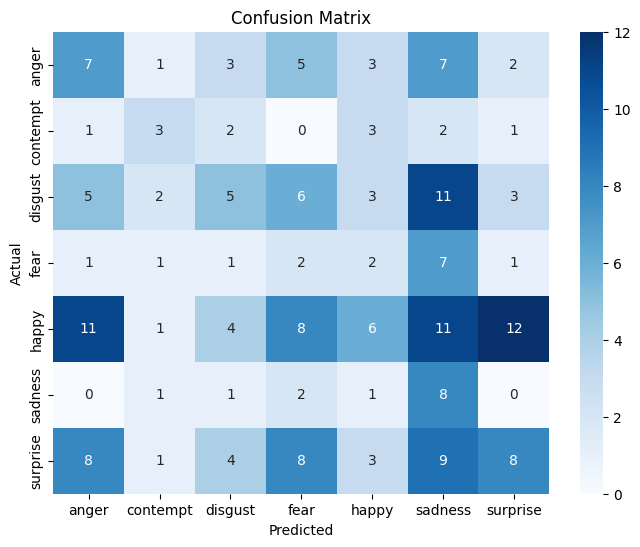

Classification Report:
              precision    recall  f1-score   support

       anger       0.21      0.25      0.23        28
    contempt       0.30      0.25      0.27        12
     disgust       0.25      0.14      0.18        35
        fear       0.06      0.13      0.09        15
       happy       0.29      0.11      0.16        53
     sadness       0.15      0.62      0.24        13
    surprise       0.30      0.20      0.24        41

    accuracy                           0.20       197
   macro avg       0.22      0.24      0.20       197
weighted avg       0.25      0.20      0.20       197

Best Model Saved!
Epoch [2/50], Loss: 1.8954
Test Accuracy: 38.58%


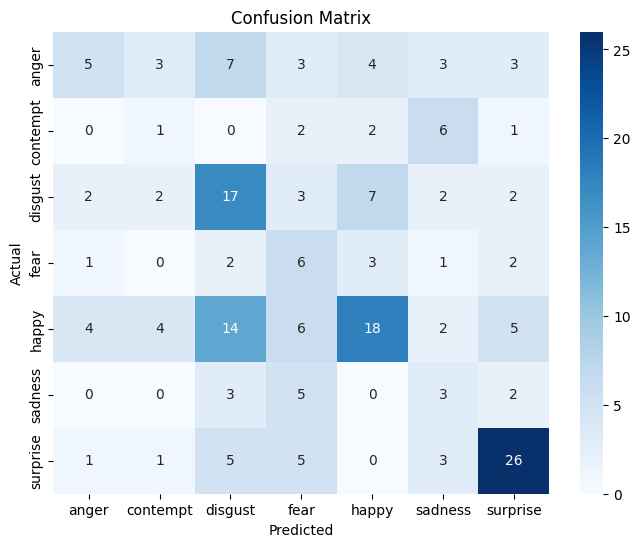

Classification Report:
              precision    recall  f1-score   support

       anger       0.38      0.18      0.24        28
    contempt       0.09      0.08      0.09        12
     disgust       0.35      0.49      0.41        35
        fear       0.20      0.40      0.27        15
       happy       0.53      0.34      0.41        53
     sadness       0.15      0.23      0.18        13
    surprise       0.63      0.63      0.63        41

    accuracy                           0.39       197
   macro avg       0.33      0.34      0.32       197
weighted avg       0.42      0.39      0.39       197

Best Model Saved!
Epoch [3/50], Loss: 1.6251
Test Accuracy: 62.44%


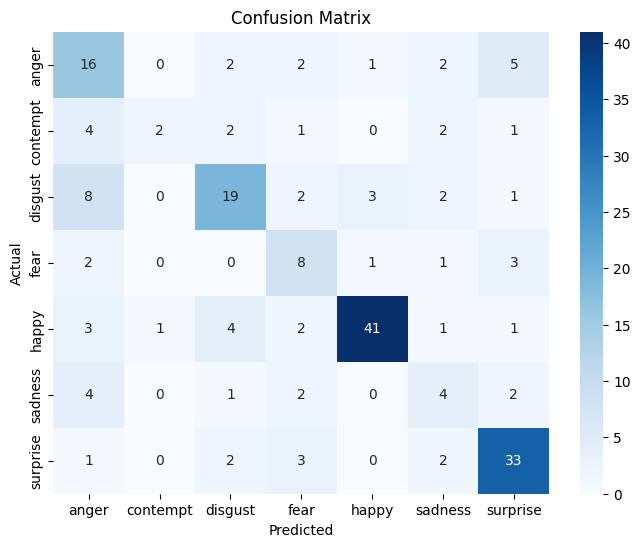

Classification Report:
              precision    recall  f1-score   support

       anger       0.42      0.57      0.48        28
    contempt       0.67      0.17      0.27        12
     disgust       0.63      0.54      0.58        35
        fear       0.40      0.53      0.46        15
       happy       0.89      0.77      0.83        53
     sadness       0.29      0.31      0.30        13
    surprise       0.72      0.80      0.76        41

    accuracy                           0.62       197
   macro avg       0.57      0.53      0.53       197
weighted avg       0.65      0.62      0.62       197

Best Model Saved!
Epoch [4/50], Loss: 1.2268
Test Accuracy: 61.93%


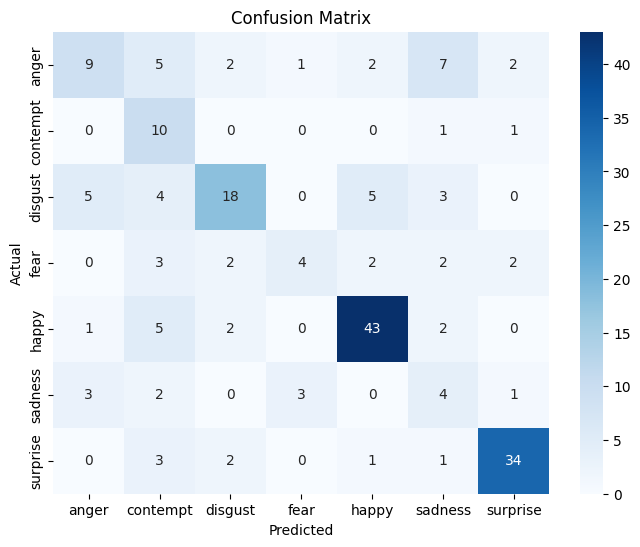

Classification Report:
              precision    recall  f1-score   support

       anger       0.50      0.32      0.39        28
    contempt       0.31      0.83      0.45        12
     disgust       0.69      0.51      0.59        35
        fear       0.50      0.27      0.35        15
       happy       0.81      0.81      0.81        53
     sadness       0.20      0.31      0.24        13
    surprise       0.85      0.83      0.84        41

    accuracy                           0.62       197
   macro avg       0.55      0.55      0.53       197
weighted avg       0.66      0.62      0.62       197

Epoch [5/50], Loss: 0.9013
Test Accuracy: 69.54%


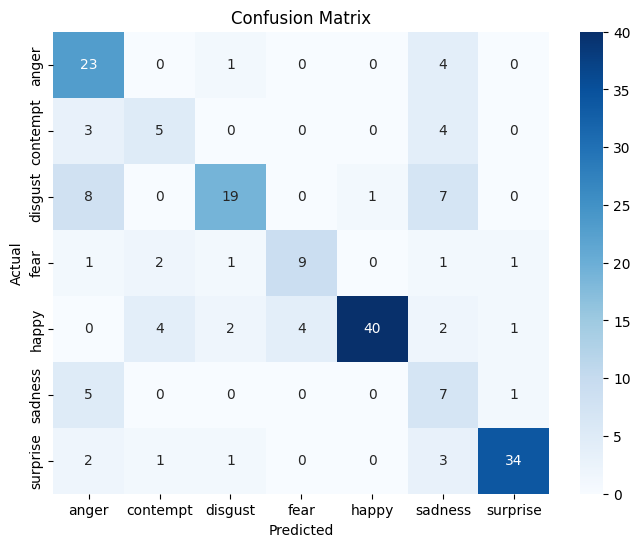

Classification Report:
              precision    recall  f1-score   support

       anger       0.55      0.82      0.66        28
    contempt       0.42      0.42      0.42        12
     disgust       0.79      0.54      0.64        35
        fear       0.69      0.60      0.64        15
       happy       0.98      0.75      0.85        53
     sadness       0.25      0.54      0.34        13
    surprise       0.92      0.83      0.87        41

    accuracy                           0.70       197
   macro avg       0.66      0.64      0.63       197
weighted avg       0.77      0.70      0.72       197

Best Model Saved!
Epoch [6/50], Loss: 0.7027
Test Accuracy: 80.71%


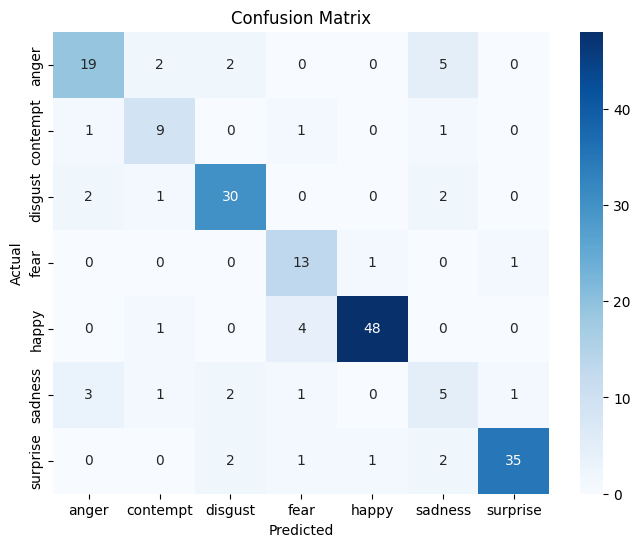

Classification Report:
              precision    recall  f1-score   support

       anger       0.76      0.68      0.72        28
    contempt       0.64      0.75      0.69        12
     disgust       0.83      0.86      0.85        35
        fear       0.65      0.87      0.74        15
       happy       0.96      0.91      0.93        53
     sadness       0.33      0.38      0.36        13
    surprise       0.95      0.85      0.90        41

    accuracy                           0.81       197
   macro avg       0.73      0.76      0.74       197
weighted avg       0.82      0.81      0.81       197

Best Model Saved!
Epoch [7/50], Loss: 0.6222
Test Accuracy: 76.65%


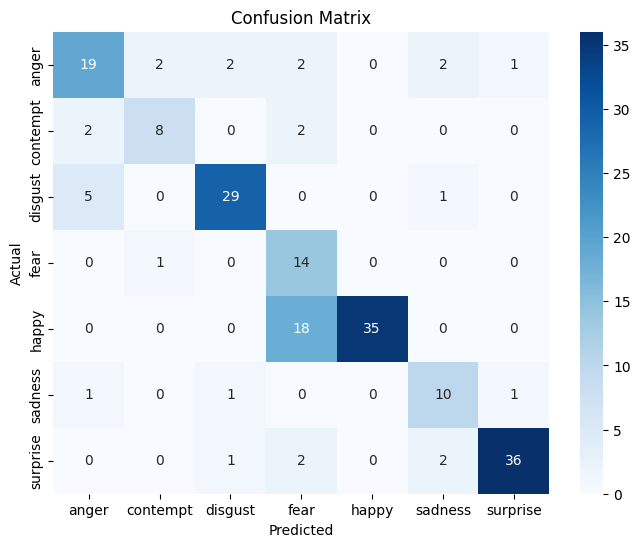

Classification Report:
              precision    recall  f1-score   support

       anger       0.70      0.68      0.69        28
    contempt       0.73      0.67      0.70        12
     disgust       0.88      0.83      0.85        35
        fear       0.37      0.93      0.53        15
       happy       1.00      0.66      0.80        53
     sadness       0.67      0.77      0.71        13
    surprise       0.95      0.88      0.91        41

    accuracy                           0.77       197
   macro avg       0.76      0.77      0.74       197
weighted avg       0.84      0.77      0.78       197

Epoch [8/50], Loss: 0.5914
Test Accuracy: 81.22%


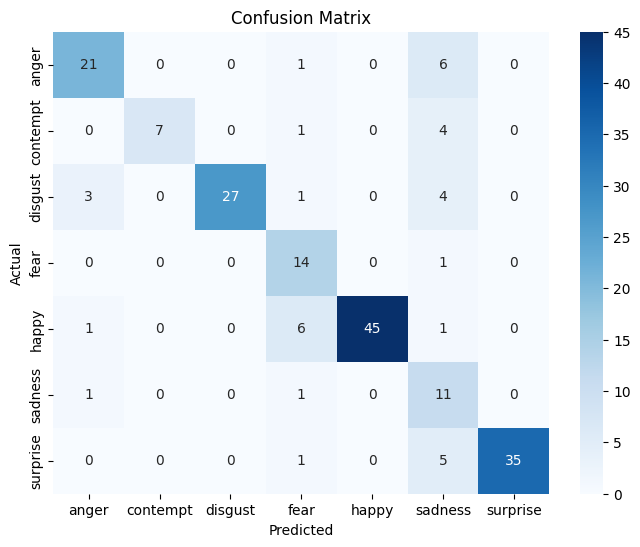

Classification Report:
              precision    recall  f1-score   support

       anger       0.81      0.75      0.78        28
    contempt       1.00      0.58      0.74        12
     disgust       1.00      0.77      0.87        35
        fear       0.56      0.93      0.70        15
       happy       1.00      0.85      0.92        53
     sadness       0.34      0.85      0.49        13
    surprise       1.00      0.85      0.92        41

    accuracy                           0.81       197
   macro avg       0.82      0.80      0.77       197
weighted avg       0.90      0.81      0.83       197

Best Model Saved!
Epoch [9/50], Loss: 0.4841
Test Accuracy: 88.32%


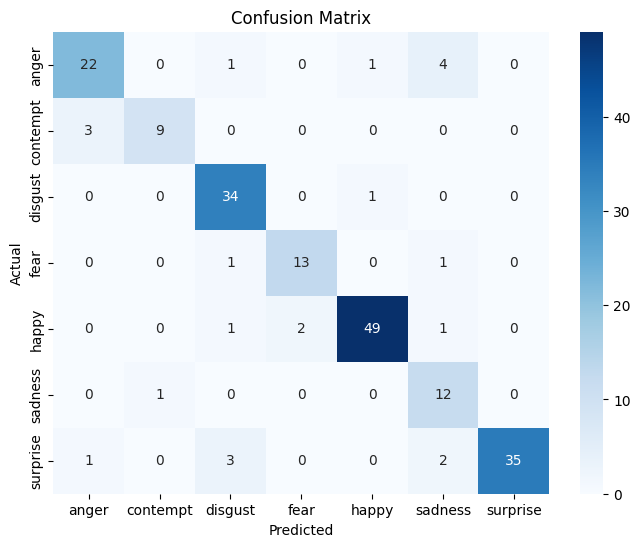

Classification Report:
              precision    recall  f1-score   support

       anger       0.85      0.79      0.81        28
    contempt       0.90      0.75      0.82        12
     disgust       0.85      0.97      0.91        35
        fear       0.87      0.87      0.87        15
       happy       0.96      0.92      0.94        53
     sadness       0.60      0.92      0.73        13
    surprise       1.00      0.85      0.92        41

    accuracy                           0.88       197
   macro avg       0.86      0.87      0.86       197
weighted avg       0.90      0.88      0.89       197

Best Model Saved!
Epoch [10/50], Loss: 0.4591
Test Accuracy: 85.79%


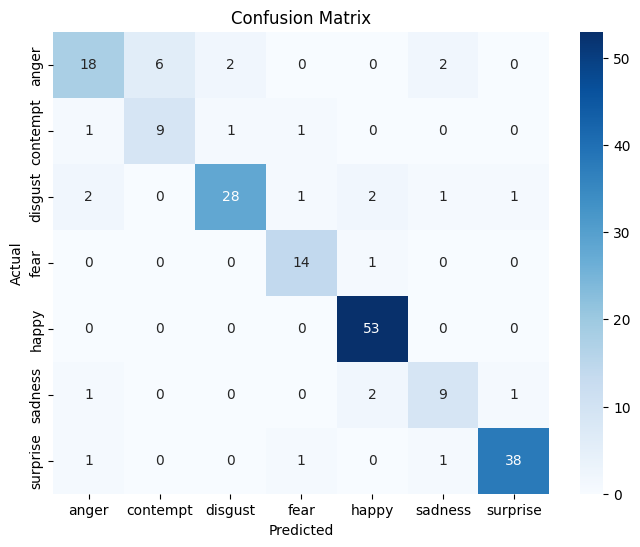

Classification Report:
              precision    recall  f1-score   support

       anger       0.78      0.64      0.71        28
    contempt       0.60      0.75      0.67        12
     disgust       0.90      0.80      0.85        35
        fear       0.82      0.93      0.88        15
       happy       0.91      1.00      0.95        53
     sadness       0.69      0.69      0.69        13
    surprise       0.95      0.93      0.94        41

    accuracy                           0.86       197
   macro avg       0.81      0.82      0.81       197
weighted avg       0.86      0.86      0.86       197

Epoch [11/50], Loss: 0.3670
Test Accuracy: 87.31%


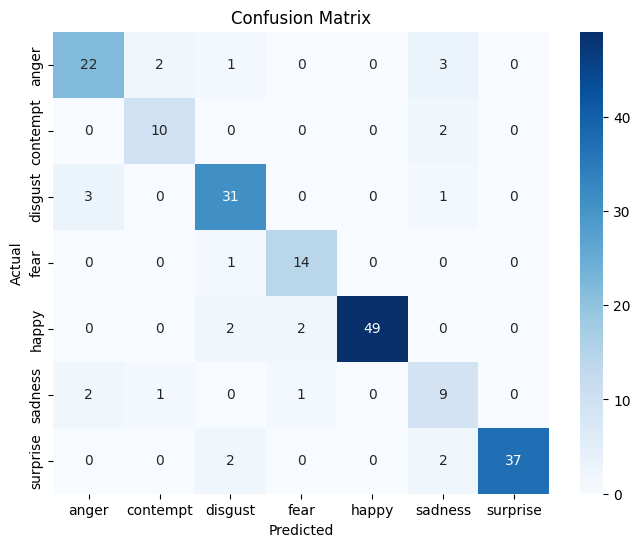

Classification Report:
              precision    recall  f1-score   support

       anger       0.81      0.79      0.80        28
    contempt       0.77      0.83      0.80        12
     disgust       0.84      0.89      0.86        35
        fear       0.82      0.93      0.88        15
       happy       1.00      0.92      0.96        53
     sadness       0.53      0.69      0.60        13
    surprise       1.00      0.90      0.95        41

    accuracy                           0.87       197
   macro avg       0.82      0.85      0.84       197
weighted avg       0.89      0.87      0.88       197

Epoch [12/50], Loss: 0.2992
Test Accuracy: 87.82%


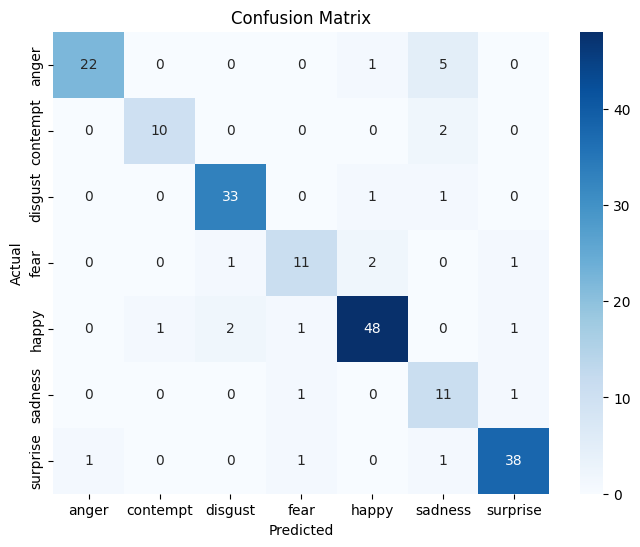

Classification Report:
              precision    recall  f1-score   support

       anger       0.96      0.79      0.86        28
    contempt       0.91      0.83      0.87        12
     disgust       0.92      0.94      0.93        35
        fear       0.79      0.73      0.76        15
       happy       0.92      0.91      0.91        53
     sadness       0.55      0.85      0.67        13
    surprise       0.93      0.93      0.93        41

    accuracy                           0.88       197
   macro avg       0.85      0.85      0.85       197
weighted avg       0.89      0.88      0.88       197

Epoch [13/50], Loss: 0.2729
Test Accuracy: 88.32%


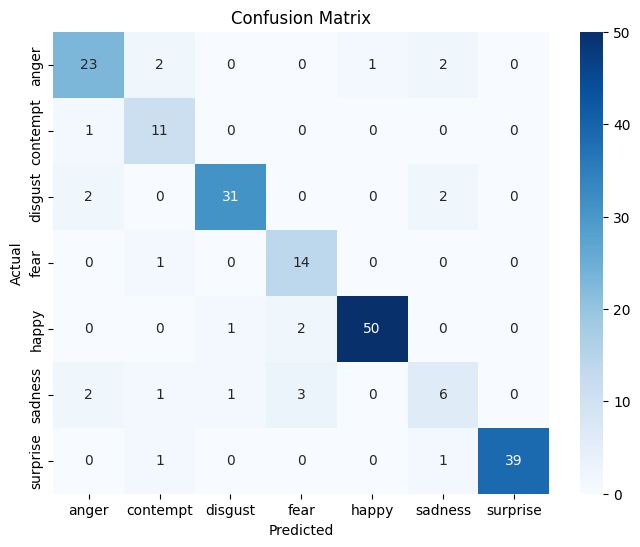

Classification Report:
              precision    recall  f1-score   support

       anger       0.82      0.82      0.82        28
    contempt       0.69      0.92      0.79        12
     disgust       0.94      0.89      0.91        35
        fear       0.74      0.93      0.82        15
       happy       0.98      0.94      0.96        53
     sadness       0.55      0.46      0.50        13
    surprise       1.00      0.95      0.97        41

    accuracy                           0.88       197
   macro avg       0.82      0.84      0.83       197
weighted avg       0.89      0.88      0.88       197

Epoch [14/50], Loss: 0.2790
Test Accuracy: 88.32%


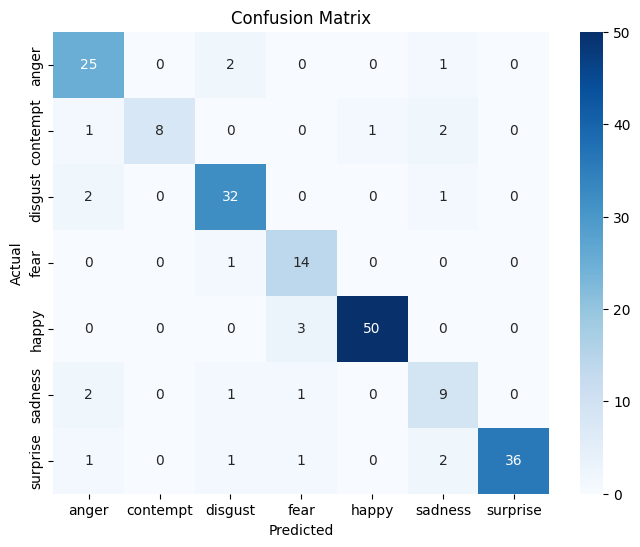

Classification Report:
              precision    recall  f1-score   support

       anger       0.81      0.89      0.85        28
    contempt       1.00      0.67      0.80        12
     disgust       0.86      0.91      0.89        35
        fear       0.74      0.93      0.82        15
       happy       0.98      0.94      0.96        53
     sadness       0.60      0.69      0.64        13
    surprise       1.00      0.88      0.94        41

    accuracy                           0.88       197
   macro avg       0.86      0.85      0.84       197
weighted avg       0.90      0.88      0.89       197

Epoch [15/50], Loss: 0.2514
Test Accuracy: 88.32%


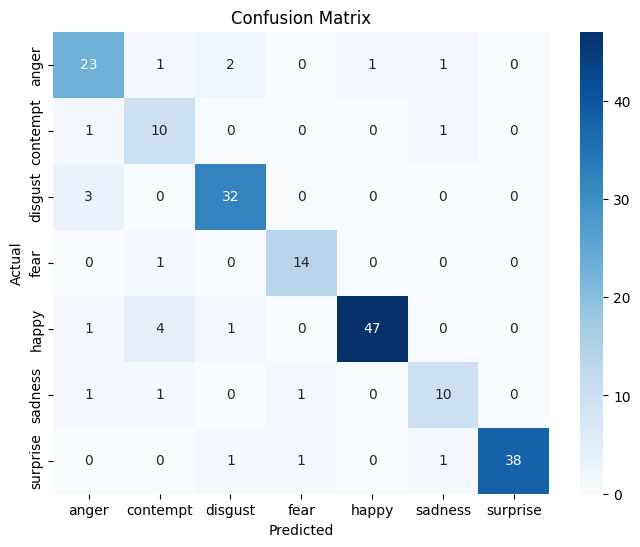

Classification Report:
              precision    recall  f1-score   support

       anger       0.79      0.82      0.81        28
    contempt       0.59      0.83      0.69        12
     disgust       0.89      0.91      0.90        35
        fear       0.88      0.93      0.90        15
       happy       0.98      0.89      0.93        53
     sadness       0.77      0.77      0.77        13
    surprise       1.00      0.93      0.96        41

    accuracy                           0.88       197
   macro avg       0.84      0.87      0.85       197
weighted avg       0.90      0.88      0.89       197

Epoch [16/50], Loss: 0.2202
Test Accuracy: 89.34%


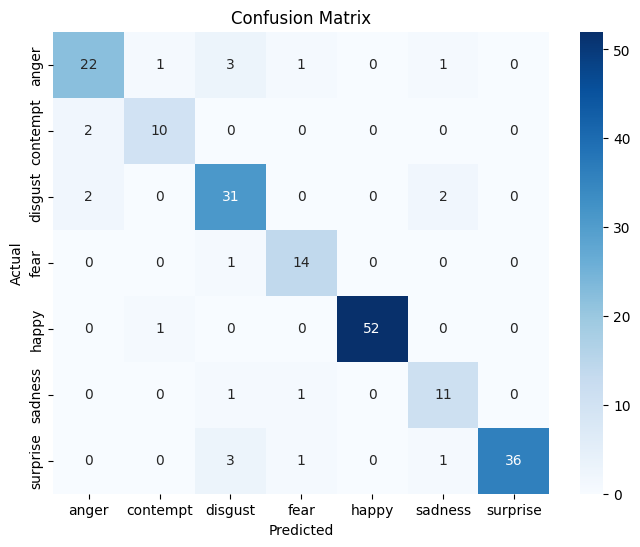

Classification Report:
              precision    recall  f1-score   support

       anger       0.85      0.79      0.81        28
    contempt       0.83      0.83      0.83        12
     disgust       0.79      0.89      0.84        35
        fear       0.82      0.93      0.88        15
       happy       1.00      0.98      0.99        53
     sadness       0.73      0.85      0.79        13
    surprise       1.00      0.88      0.94        41

    accuracy                           0.89       197
   macro avg       0.86      0.88      0.87       197
weighted avg       0.90      0.89      0.89       197

Best Model Saved!
Epoch [17/50], Loss: 0.2447
Test Accuracy: 87.82%


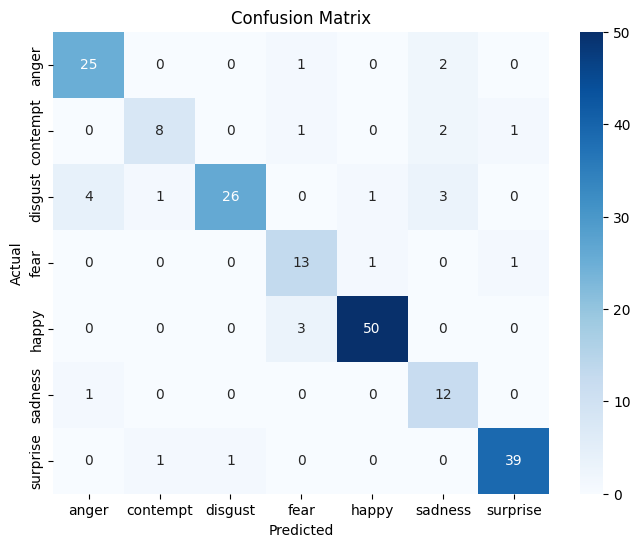

Classification Report:
              precision    recall  f1-score   support

       anger       0.83      0.89      0.86        28
    contempt       0.80      0.67      0.73        12
     disgust       0.96      0.74      0.84        35
        fear       0.72      0.87      0.79        15
       happy       0.96      0.94      0.95        53
     sadness       0.63      0.92      0.75        13
    surprise       0.95      0.95      0.95        41

    accuracy                           0.88       197
   macro avg       0.84      0.86      0.84       197
weighted avg       0.89      0.88      0.88       197

Epoch [18/50], Loss: 0.2292
Test Accuracy: 91.37%


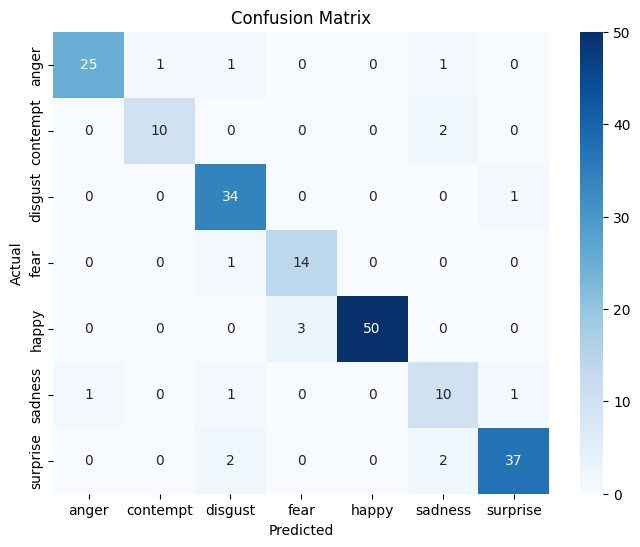

Classification Report:
              precision    recall  f1-score   support

       anger       0.96      0.89      0.93        28
    contempt       0.91      0.83      0.87        12
     disgust       0.87      0.97      0.92        35
        fear       0.82      0.93      0.88        15
       happy       1.00      0.94      0.97        53
     sadness       0.67      0.77      0.71        13
    surprise       0.95      0.90      0.93        41

    accuracy                           0.91       197
   macro avg       0.88      0.89      0.89       197
weighted avg       0.92      0.91      0.92       197

Best Model Saved!
Epoch [19/50], Loss: 0.1845
Test Accuracy: 91.37%


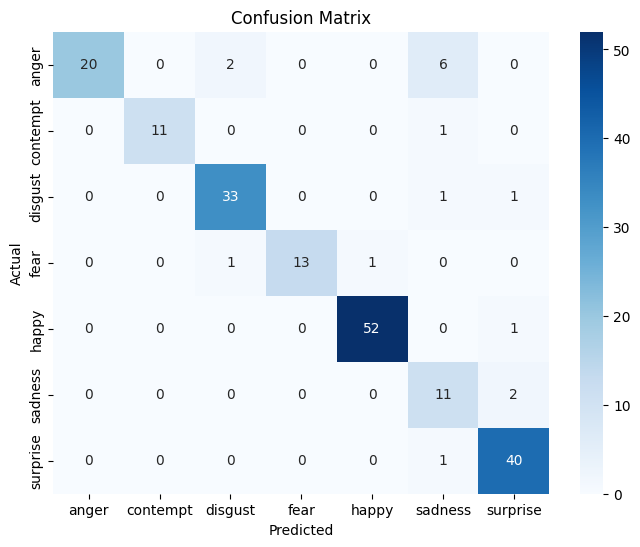

Classification Report:
              precision    recall  f1-score   support

       anger       1.00      0.71      0.83        28
    contempt       1.00      0.92      0.96        12
     disgust       0.92      0.94      0.93        35
        fear       1.00      0.87      0.93        15
       happy       0.98      0.98      0.98        53
     sadness       0.55      0.85      0.67        13
    surprise       0.91      0.98      0.94        41

    accuracy                           0.91       197
   macro avg       0.91      0.89      0.89       197
weighted avg       0.93      0.91      0.92       197

Epoch [20/50], Loss: 0.1723
Test Accuracy: 90.86%


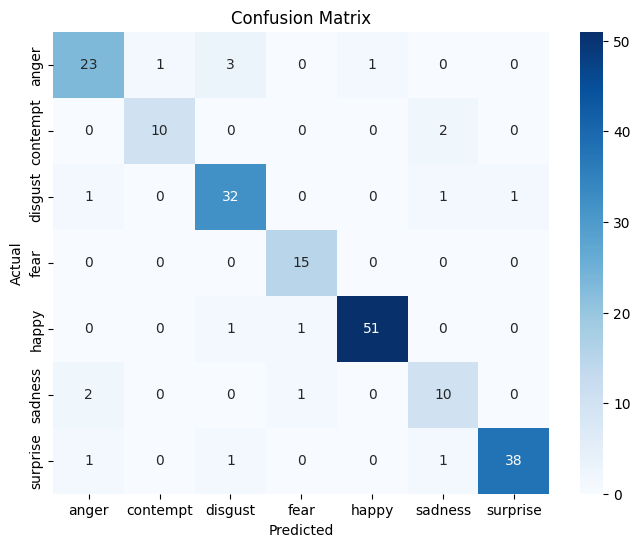

Classification Report:
              precision    recall  f1-score   support

       anger       0.85      0.82      0.84        28
    contempt       0.91      0.83      0.87        12
     disgust       0.86      0.91      0.89        35
        fear       0.88      1.00      0.94        15
       happy       0.98      0.96      0.97        53
     sadness       0.71      0.77      0.74        13
    surprise       0.97      0.93      0.95        41

    accuracy                           0.91       197
   macro avg       0.88      0.89      0.88       197
weighted avg       0.91      0.91      0.91       197

Epoch [21/50], Loss: 0.2000
Test Accuracy: 91.88%


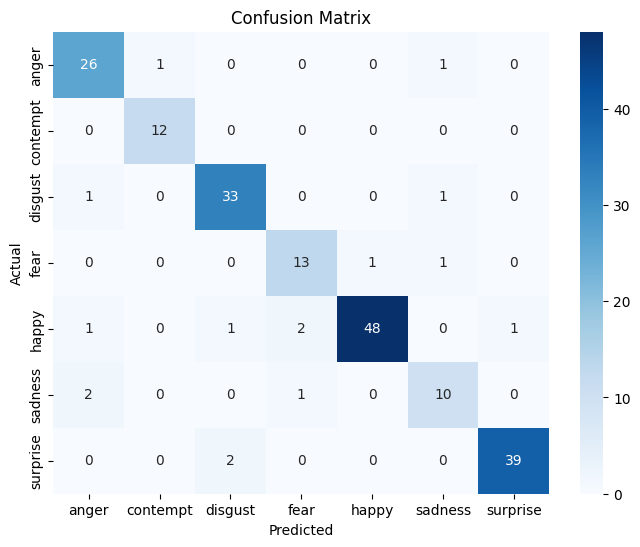

Classification Report:
              precision    recall  f1-score   support

       anger       0.87      0.93      0.90        28
    contempt       0.92      1.00      0.96        12
     disgust       0.92      0.94      0.93        35
        fear       0.81      0.87      0.84        15
       happy       0.98      0.91      0.94        53
     sadness       0.77      0.77      0.77        13
    surprise       0.97      0.95      0.96        41

    accuracy                           0.92       197
   macro avg       0.89      0.91      0.90       197
weighted avg       0.92      0.92      0.92       197

Best Model Saved!
Epoch [22/50], Loss: 0.1709
Test Accuracy: 91.88%


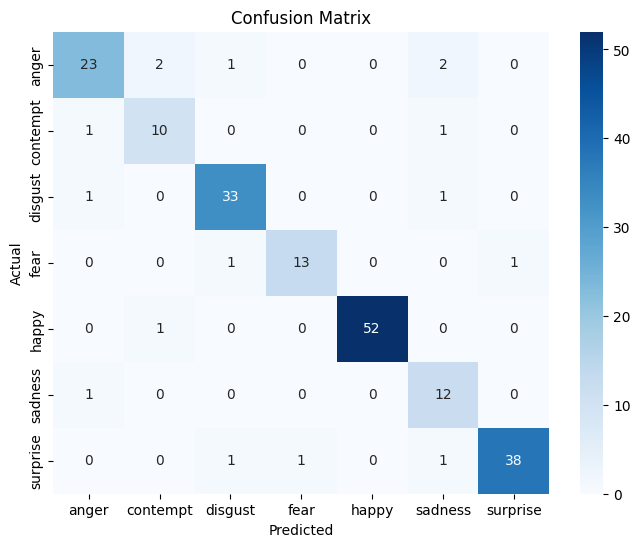

Classification Report:
              precision    recall  f1-score   support

       anger       0.88      0.82      0.85        28
    contempt       0.77      0.83      0.80        12
     disgust       0.92      0.94      0.93        35
        fear       0.93      0.87      0.90        15
       happy       1.00      0.98      0.99        53
     sadness       0.71      0.92      0.80        13
    surprise       0.97      0.93      0.95        41

    accuracy                           0.92       197
   macro avg       0.88      0.90      0.89       197
weighted avg       0.92      0.92      0.92       197

Epoch [23/50], Loss: 0.1973
Test Accuracy: 87.31%


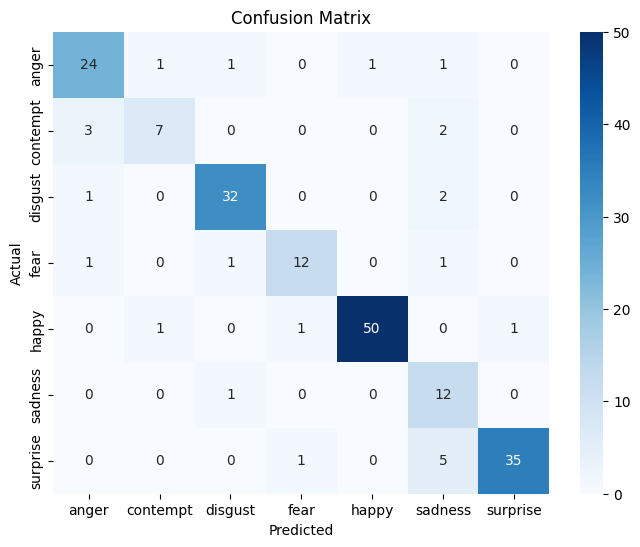

Classification Report:
              precision    recall  f1-score   support

       anger       0.83      0.86      0.84        28
    contempt       0.78      0.58      0.67        12
     disgust       0.91      0.91      0.91        35
        fear       0.86      0.80      0.83        15
       happy       0.98      0.94      0.96        53
     sadness       0.52      0.92      0.67        13
    surprise       0.97      0.85      0.91        41

    accuracy                           0.87       197
   macro avg       0.84      0.84      0.83       197
weighted avg       0.89      0.87      0.88       197

Epoch [24/50], Loss: 0.1827
Test Accuracy: 91.88%


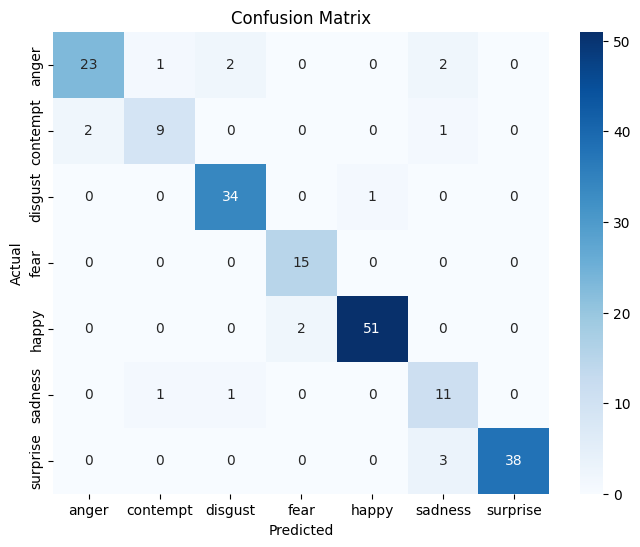

Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.82      0.87        28
    contempt       0.82      0.75      0.78        12
     disgust       0.92      0.97      0.94        35
        fear       0.88      1.00      0.94        15
       happy       0.98      0.96      0.97        53
     sadness       0.65      0.85      0.73        13
    surprise       1.00      0.93      0.96        41

    accuracy                           0.92       197
   macro avg       0.88      0.90      0.89       197
weighted avg       0.93      0.92      0.92       197

Epoch [25/50], Loss: 0.2057
Test Accuracy: 91.88%


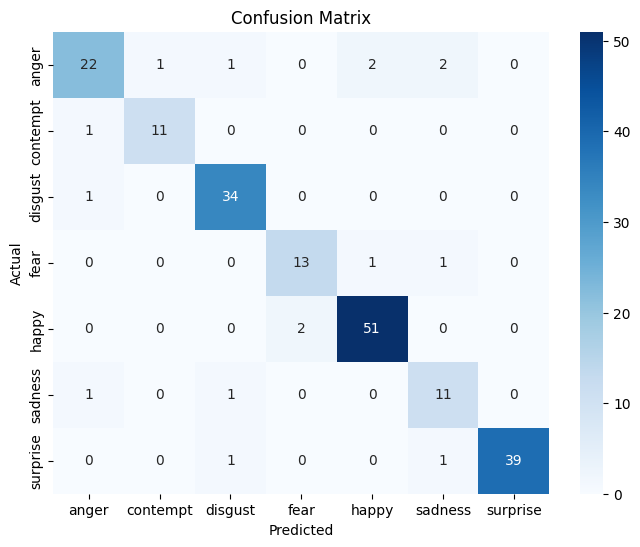

Classification Report:
              precision    recall  f1-score   support

       anger       0.88      0.79      0.83        28
    contempt       0.92      0.92      0.92        12
     disgust       0.92      0.97      0.94        35
        fear       0.87      0.87      0.87        15
       happy       0.94      0.96      0.95        53
     sadness       0.73      0.85      0.79        13
    surprise       1.00      0.95      0.97        41

    accuracy                           0.92       197
   macro avg       0.89      0.90      0.90       197
weighted avg       0.92      0.92      0.92       197

Epoch [26/50], Loss: 0.1625
Test Accuracy: 94.42%


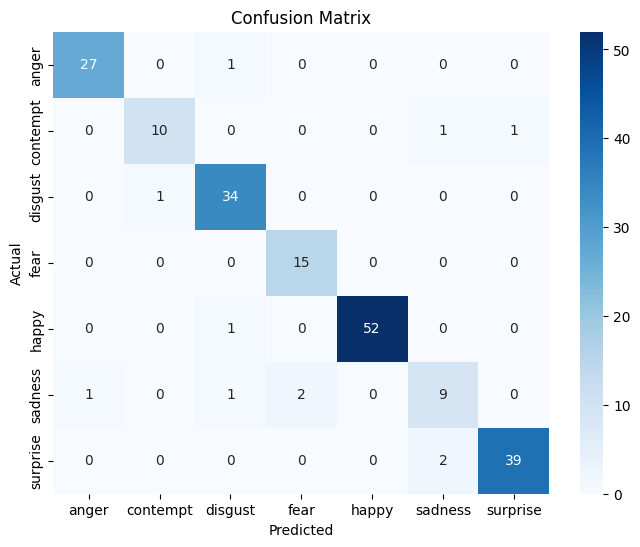

Classification Report:
              precision    recall  f1-score   support

       anger       0.96      0.96      0.96        28
    contempt       0.91      0.83      0.87        12
     disgust       0.92      0.97      0.94        35
        fear       0.88      1.00      0.94        15
       happy       1.00      0.98      0.99        53
     sadness       0.75      0.69      0.72        13
    surprise       0.97      0.95      0.96        41

    accuracy                           0.94       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.94      0.94      0.94       197

Best Model Saved!
Epoch [27/50], Loss: 0.1577
Test Accuracy: 89.85%


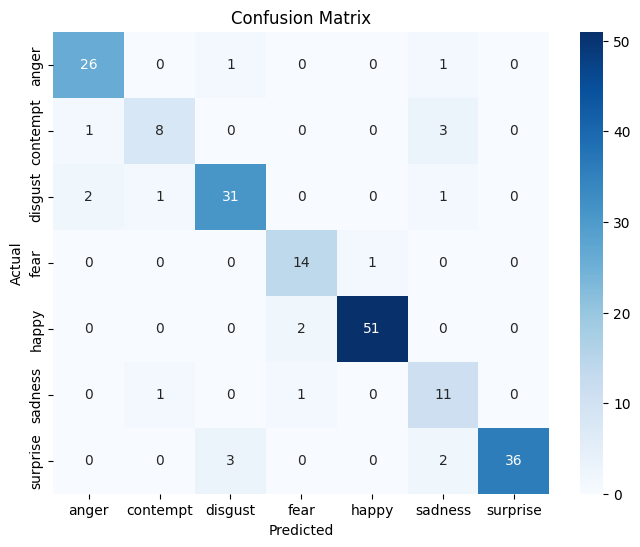

Classification Report:
              precision    recall  f1-score   support

       anger       0.90      0.93      0.91        28
    contempt       0.80      0.67      0.73        12
     disgust       0.89      0.89      0.89        35
        fear       0.82      0.93      0.88        15
       happy       0.98      0.96      0.97        53
     sadness       0.61      0.85      0.71        13
    surprise       1.00      0.88      0.94        41

    accuracy                           0.90       197
   macro avg       0.86      0.87      0.86       197
weighted avg       0.91      0.90      0.90       197

Epoch [28/50], Loss: 0.2041
Test Accuracy: 90.36%


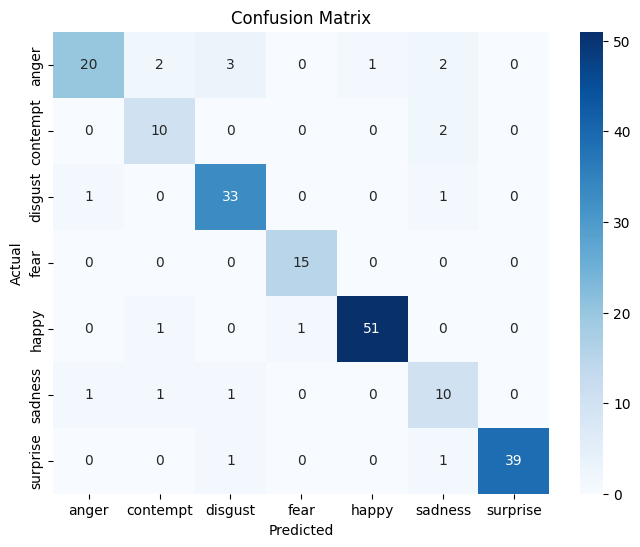

Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.71      0.80        28
    contempt       0.71      0.83      0.77        12
     disgust       0.87      0.94      0.90        35
        fear       0.94      1.00      0.97        15
       happy       0.98      0.96      0.97        53
     sadness       0.62      0.77      0.69        13
    surprise       1.00      0.95      0.97        41

    accuracy                           0.90       197
   macro avg       0.86      0.88      0.87       197
weighted avg       0.91      0.90      0.90       197

Epoch [29/50], Loss: 0.1949
Test Accuracy: 91.37%


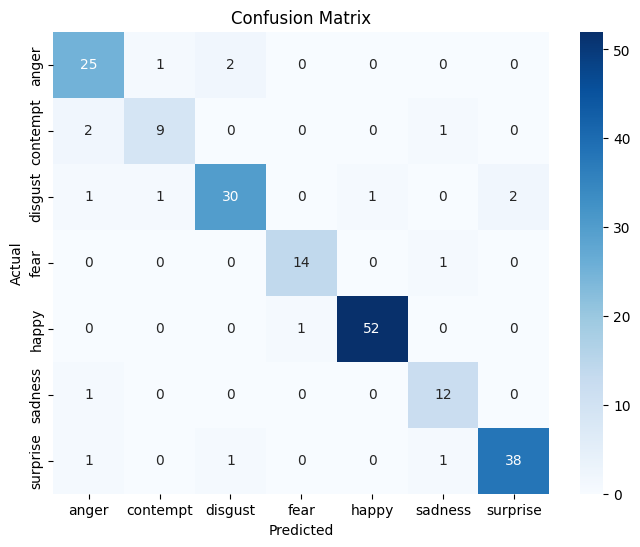

Classification Report:
              precision    recall  f1-score   support

       anger       0.83      0.89      0.86        28
    contempt       0.82      0.75      0.78        12
     disgust       0.91      0.86      0.88        35
        fear       0.93      0.93      0.93        15
       happy       0.98      0.98      0.98        53
     sadness       0.80      0.92      0.86        13
    surprise       0.95      0.93      0.94        41

    accuracy                           0.91       197
   macro avg       0.89      0.89      0.89       197
weighted avg       0.92      0.91      0.91       197

Epoch [30/50], Loss: 0.1794
Test Accuracy: 88.83%


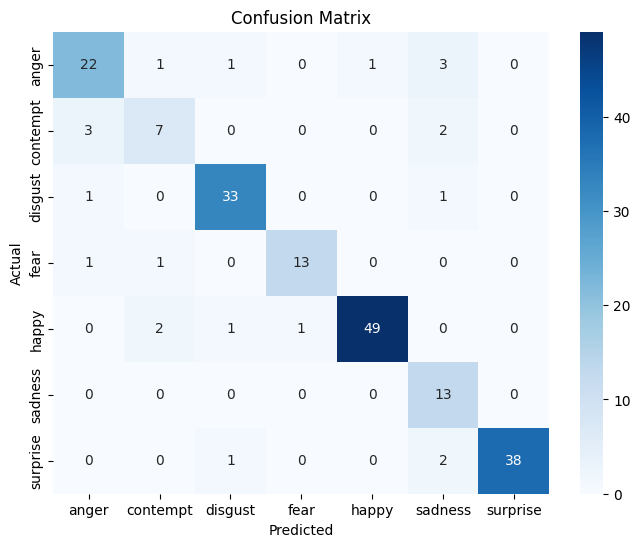

Classification Report:
              precision    recall  f1-score   support

       anger       0.81      0.79      0.80        28
    contempt       0.64      0.58      0.61        12
     disgust       0.92      0.94      0.93        35
        fear       0.93      0.87      0.90        15
       happy       0.98      0.92      0.95        53
     sadness       0.62      1.00      0.76        13
    surprise       1.00      0.93      0.96        41

    accuracy                           0.89       197
   macro avg       0.84      0.86      0.84       197
weighted avg       0.90      0.89      0.89       197

Epoch [31/50], Loss: 0.1621
Test Accuracy: 92.39%


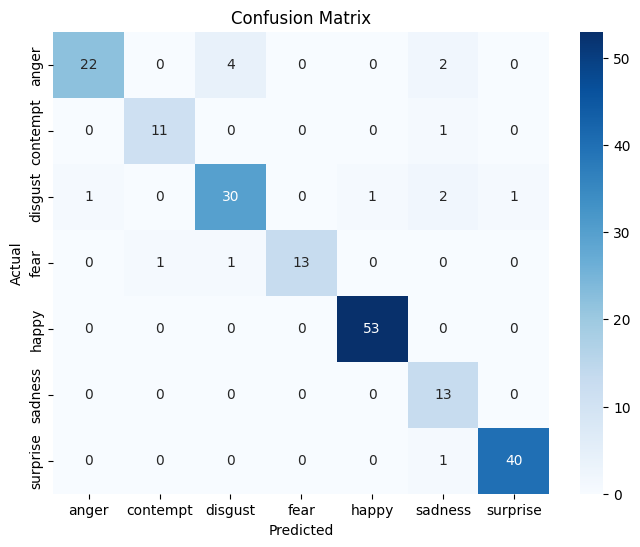

Classification Report:
              precision    recall  f1-score   support

       anger       0.96      0.79      0.86        28
    contempt       0.92      0.92      0.92        12
     disgust       0.86      0.86      0.86        35
        fear       1.00      0.87      0.93        15
       happy       0.98      1.00      0.99        53
     sadness       0.68      1.00      0.81        13
    surprise       0.98      0.98      0.98        41

    accuracy                           0.92       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.93      0.92      0.92       197

Epoch [32/50], Loss: 0.1330
Test Accuracy: 90.86%


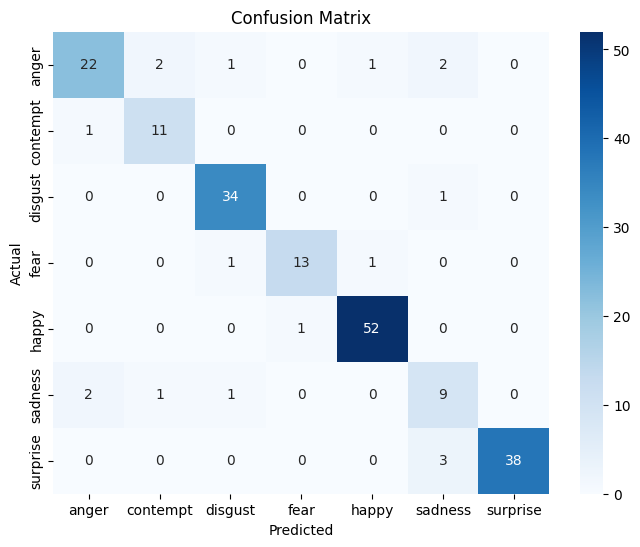

Classification Report:
              precision    recall  f1-score   support

       anger       0.88      0.79      0.83        28
    contempt       0.79      0.92      0.85        12
     disgust       0.92      0.97      0.94        35
        fear       0.93      0.87      0.90        15
       happy       0.96      0.98      0.97        53
     sadness       0.60      0.69      0.64        13
    surprise       1.00      0.93      0.96        41

    accuracy                           0.91       197
   macro avg       0.87      0.88      0.87       197
weighted avg       0.91      0.91      0.91       197

Epoch [33/50], Loss: 0.1603
Test Accuracy: 90.86%


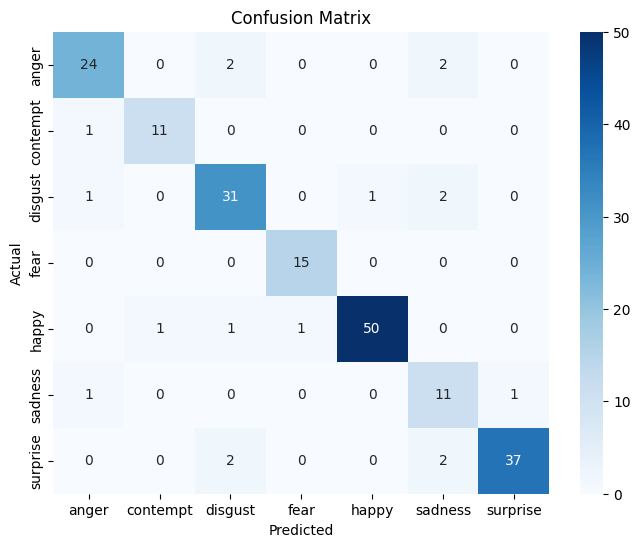

Classification Report:
              precision    recall  f1-score   support

       anger       0.89      0.86      0.87        28
    contempt       0.92      0.92      0.92        12
     disgust       0.86      0.89      0.87        35
        fear       0.94      1.00      0.97        15
       happy       0.98      0.94      0.96        53
     sadness       0.65      0.85      0.73        13
    surprise       0.97      0.90      0.94        41

    accuracy                           0.91       197
   macro avg       0.89      0.91      0.89       197
weighted avg       0.92      0.91      0.91       197

Epoch [34/50], Loss: 0.1829
Test Accuracy: 87.31%


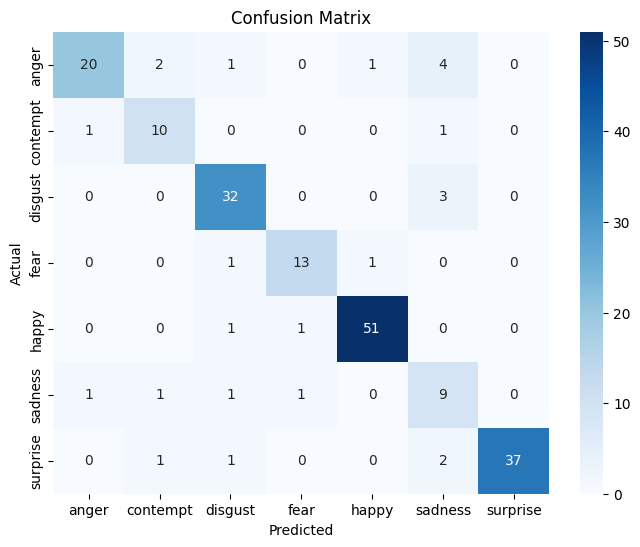

Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.71      0.80        28
    contempt       0.71      0.83      0.77        12
     disgust       0.86      0.91      0.89        35
        fear       0.87      0.87      0.87        15
       happy       0.96      0.96      0.96        53
     sadness       0.47      0.69      0.56        13
    surprise       1.00      0.90      0.95        41

    accuracy                           0.87       197
   macro avg       0.83      0.84      0.83       197
weighted avg       0.89      0.87      0.88       197

Epoch [35/50], Loss: 0.1644
Test Accuracy: 90.36%


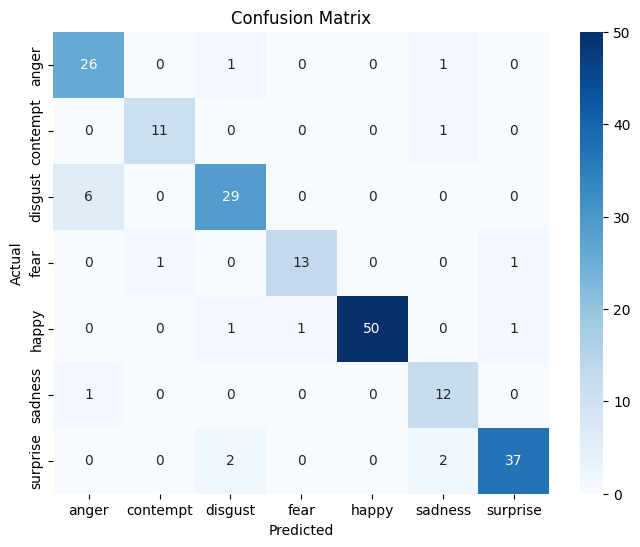

Classification Report:
              precision    recall  f1-score   support

       anger       0.79      0.93      0.85        28
    contempt       0.92      0.92      0.92        12
     disgust       0.88      0.83      0.85        35
        fear       0.93      0.87      0.90        15
       happy       1.00      0.94      0.97        53
     sadness       0.75      0.92      0.83        13
    surprise       0.95      0.90      0.93        41

    accuracy                           0.90       197
   macro avg       0.89      0.90      0.89       197
weighted avg       0.91      0.90      0.91       197

Epoch [36/50], Loss: 0.1759
Test Accuracy: 90.36%


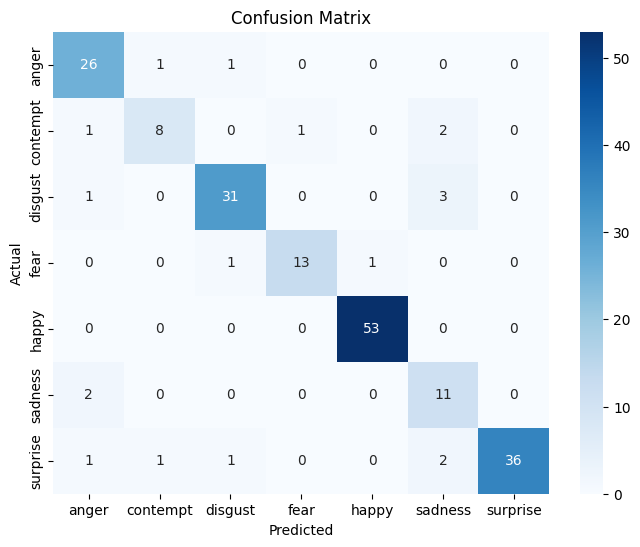

Classification Report:
              precision    recall  f1-score   support

       anger       0.84      0.93      0.88        28
    contempt       0.80      0.67      0.73        12
     disgust       0.91      0.89      0.90        35
        fear       0.93      0.87      0.90        15
       happy       0.98      1.00      0.99        53
     sadness       0.61      0.85      0.71        13
    surprise       1.00      0.88      0.94        41

    accuracy                           0.90       197
   macro avg       0.87      0.87      0.86       197
weighted avg       0.91      0.90      0.91       197

Epoch [37/50], Loss: 0.1483
Test Accuracy: 89.34%


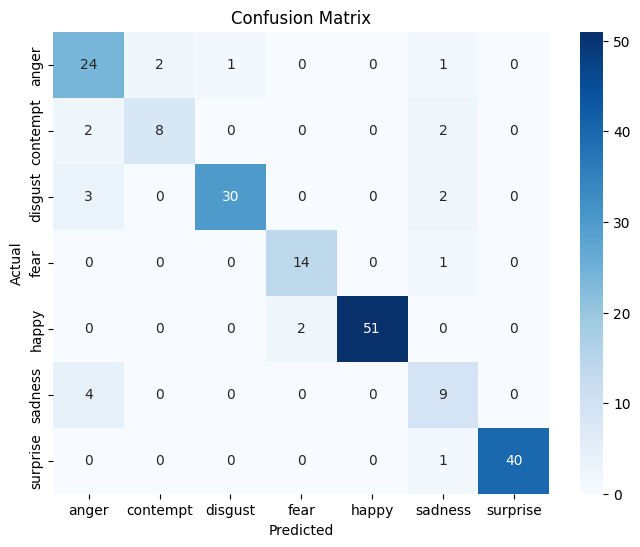

Classification Report:
              precision    recall  f1-score   support

       anger       0.73      0.86      0.79        28
    contempt       0.80      0.67      0.73        12
     disgust       0.97      0.86      0.91        35
        fear       0.88      0.93      0.90        15
       happy       1.00      0.96      0.98        53
     sadness       0.56      0.69      0.62        13
    surprise       1.00      0.98      0.99        41

    accuracy                           0.89       197
   macro avg       0.85      0.85      0.85       197
weighted avg       0.90      0.89      0.90       197

Epoch [38/50], Loss: 0.1514
Test Accuracy: 93.91%


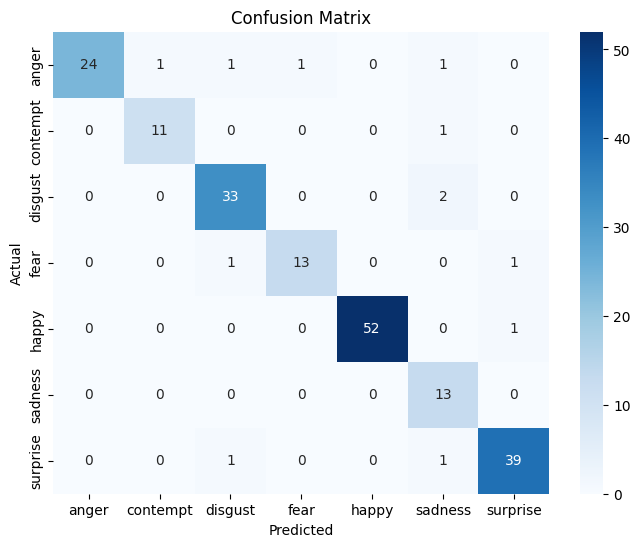

Classification Report:
              precision    recall  f1-score   support

       anger       1.00      0.86      0.92        28
    contempt       0.92      0.92      0.92        12
     disgust       0.92      0.94      0.93        35
        fear       0.93      0.87      0.90        15
       happy       1.00      0.98      0.99        53
     sadness       0.72      1.00      0.84        13
    surprise       0.95      0.95      0.95        41

    accuracy                           0.94       197
   macro avg       0.92      0.93      0.92       197
weighted avg       0.95      0.94      0.94       197

Epoch [39/50], Loss: 0.1672
Test Accuracy: 91.37%


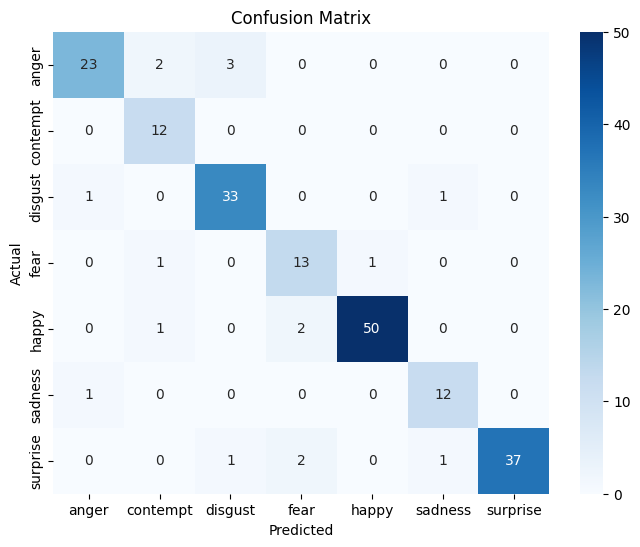

Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.82      0.87        28
    contempt       0.75      1.00      0.86        12
     disgust       0.89      0.94      0.92        35
        fear       0.76      0.87      0.81        15
       happy       0.98      0.94      0.96        53
     sadness       0.86      0.92      0.89        13
    surprise       1.00      0.90      0.95        41

    accuracy                           0.91       197
   macro avg       0.88      0.91      0.89       197
weighted avg       0.92      0.91      0.92       197

Epoch [40/50], Loss: 0.1621
Test Accuracy: 90.86%


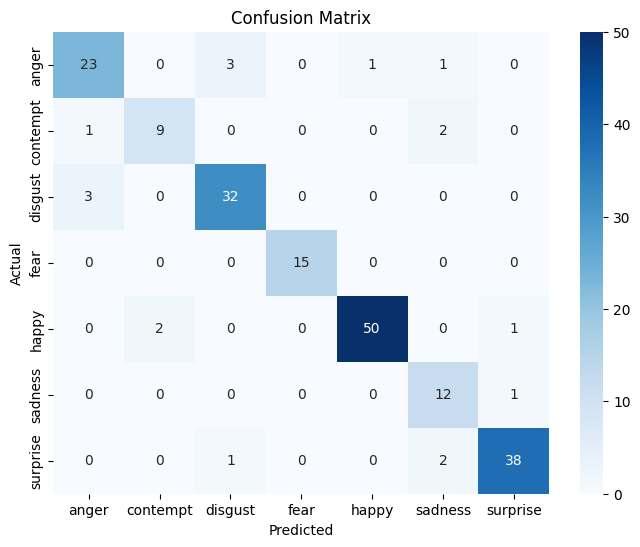

Classification Report:
              precision    recall  f1-score   support

       anger       0.85      0.82      0.84        28
    contempt       0.82      0.75      0.78        12
     disgust       0.89      0.91      0.90        35
        fear       1.00      1.00      1.00        15
       happy       0.98      0.94      0.96        53
     sadness       0.71      0.92      0.80        13
    surprise       0.95      0.93      0.94        41

    accuracy                           0.91       197
   macro avg       0.89      0.90      0.89       197
weighted avg       0.91      0.91      0.91       197

Epoch [41/50], Loss: 0.1703
Test Accuracy: 91.88%


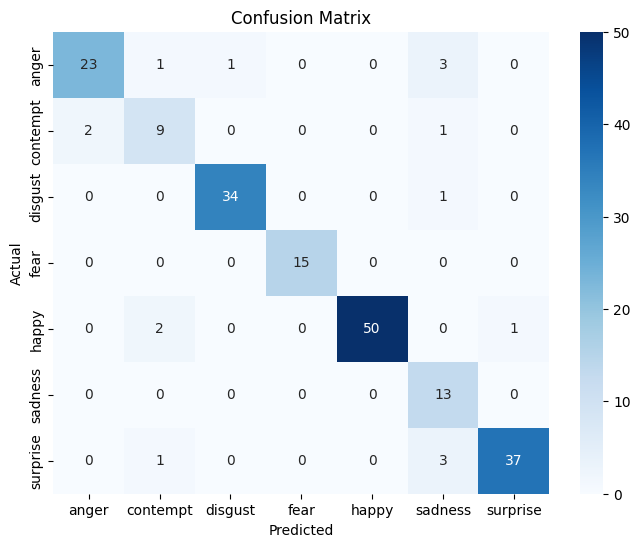

Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.82      0.87        28
    contempt       0.69      0.75      0.72        12
     disgust       0.97      0.97      0.97        35
        fear       1.00      1.00      1.00        15
       happy       1.00      0.94      0.97        53
     sadness       0.62      1.00      0.76        13
    surprise       0.97      0.90      0.94        41

    accuracy                           0.92       197
   macro avg       0.88      0.91      0.89       197
weighted avg       0.93      0.92      0.92       197

Epoch [42/50], Loss: 0.1546
Test Accuracy: 91.37%


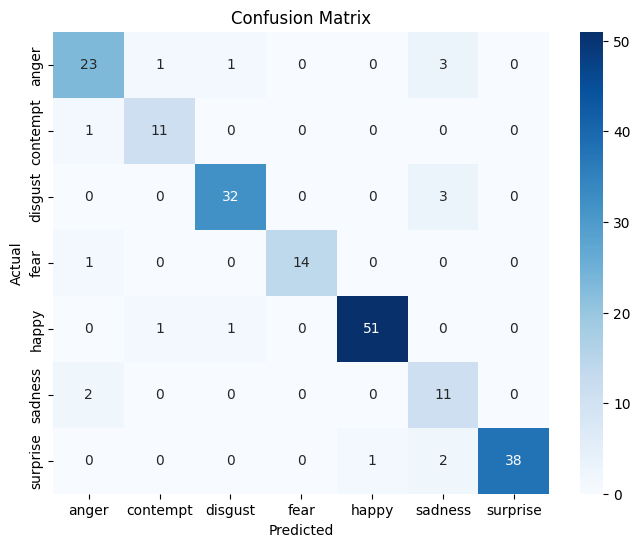

Classification Report:
              precision    recall  f1-score   support

       anger       0.85      0.82      0.84        28
    contempt       0.85      0.92      0.88        12
     disgust       0.94      0.91      0.93        35
        fear       1.00      0.93      0.97        15
       happy       0.98      0.96      0.97        53
     sadness       0.58      0.85      0.69        13
    surprise       1.00      0.93      0.96        41

    accuracy                           0.91       197
   macro avg       0.89      0.90      0.89       197
weighted avg       0.93      0.91      0.92       197

Epoch [43/50], Loss: 0.1615
Test Accuracy: 90.86%


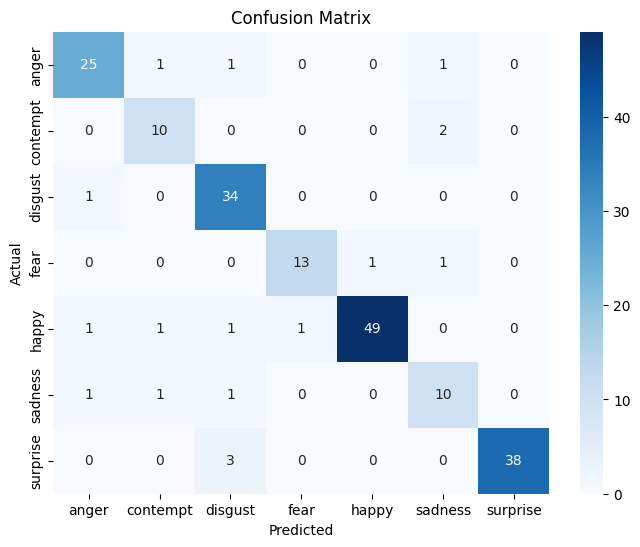

Classification Report:
              precision    recall  f1-score   support

       anger       0.89      0.89      0.89        28
    contempt       0.77      0.83      0.80        12
     disgust       0.85      0.97      0.91        35
        fear       0.93      0.87      0.90        15
       happy       0.98      0.92      0.95        53
     sadness       0.71      0.77      0.74        13
    surprise       1.00      0.93      0.96        41

    accuracy                           0.91       197
   macro avg       0.88      0.88      0.88       197
weighted avg       0.91      0.91      0.91       197

Epoch [44/50], Loss: 0.1974
Test Accuracy: 90.86%


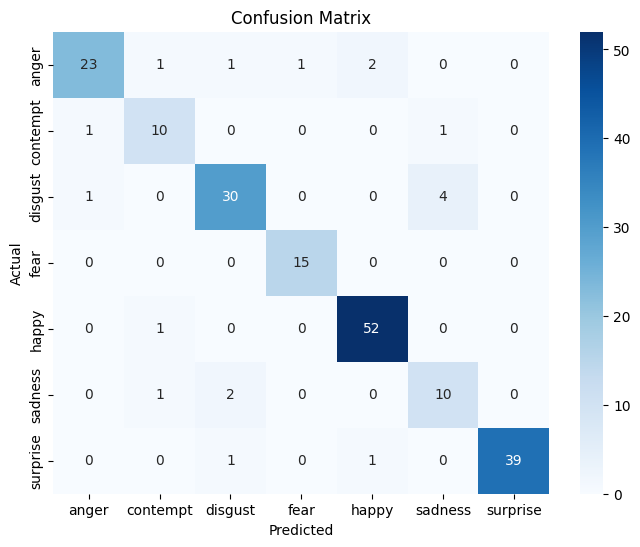

Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.82      0.87        28
    contempt       0.77      0.83      0.80        12
     disgust       0.88      0.86      0.87        35
        fear       0.94      1.00      0.97        15
       happy       0.95      0.98      0.96        53
     sadness       0.67      0.77      0.71        13
    surprise       1.00      0.95      0.97        41

    accuracy                           0.91       197
   macro avg       0.87      0.89      0.88       197
weighted avg       0.91      0.91      0.91       197

Epoch [45/50], Loss: 0.1498
Test Accuracy: 92.89%


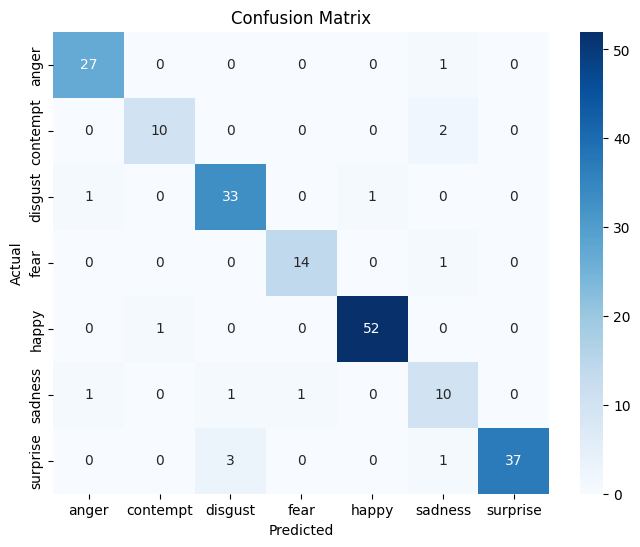

Classification Report:
              precision    recall  f1-score   support

       anger       0.93      0.96      0.95        28
    contempt       0.91      0.83      0.87        12
     disgust       0.89      0.94      0.92        35
        fear       0.93      0.93      0.93        15
       happy       0.98      0.98      0.98        53
     sadness       0.67      0.77      0.71        13
    surprise       1.00      0.90      0.95        41

    accuracy                           0.93       197
   macro avg       0.90      0.90      0.90       197
weighted avg       0.93      0.93      0.93       197

Epoch [46/50], Loss: 0.1376
Test Accuracy: 93.40%


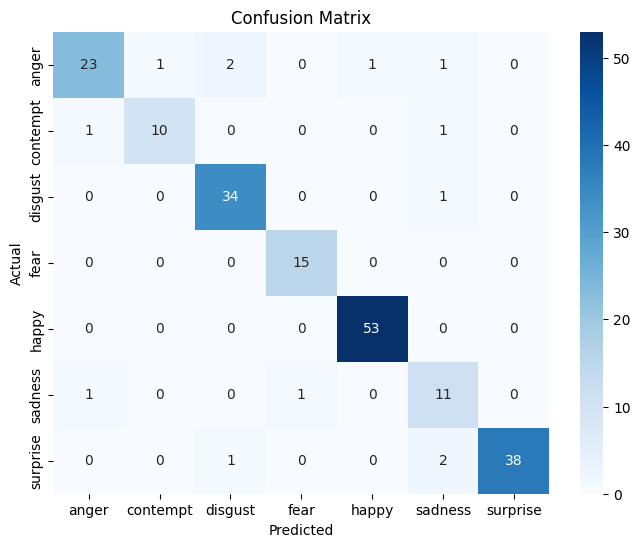

Classification Report:
              precision    recall  f1-score   support

       anger       0.92      0.82      0.87        28
    contempt       0.91      0.83      0.87        12
     disgust       0.92      0.97      0.94        35
        fear       0.94      1.00      0.97        15
       happy       0.98      1.00      0.99        53
     sadness       0.69      0.85      0.76        13
    surprise       1.00      0.93      0.96        41

    accuracy                           0.93       197
   macro avg       0.91      0.91      0.91       197
weighted avg       0.94      0.93      0.93       197

Epoch [47/50], Loss: 0.1325
Test Accuracy: 92.89%


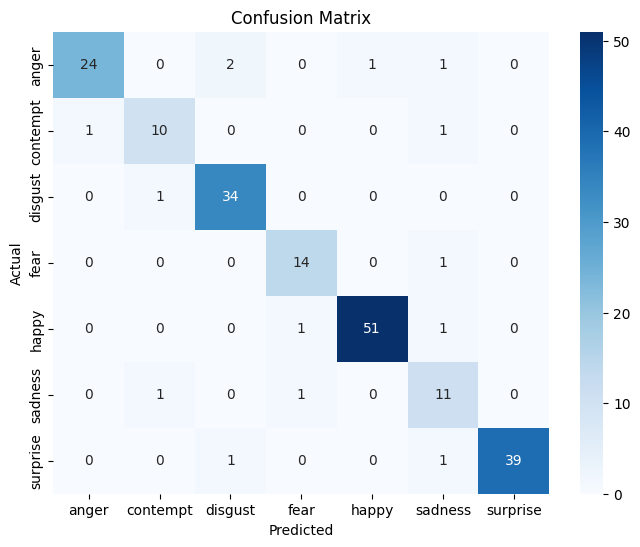

Classification Report:
              precision    recall  f1-score   support

       anger       0.96      0.86      0.91        28
    contempt       0.83      0.83      0.83        12
     disgust       0.92      0.97      0.94        35
        fear       0.88      0.93      0.90        15
       happy       0.98      0.96      0.97        53
     sadness       0.69      0.85      0.76        13
    surprise       1.00      0.95      0.97        41

    accuracy                           0.93       197
   macro avg       0.89      0.91      0.90       197
weighted avg       0.93      0.93      0.93       197

Epoch [48/50], Loss: 0.1747
Test Accuracy: 92.39%


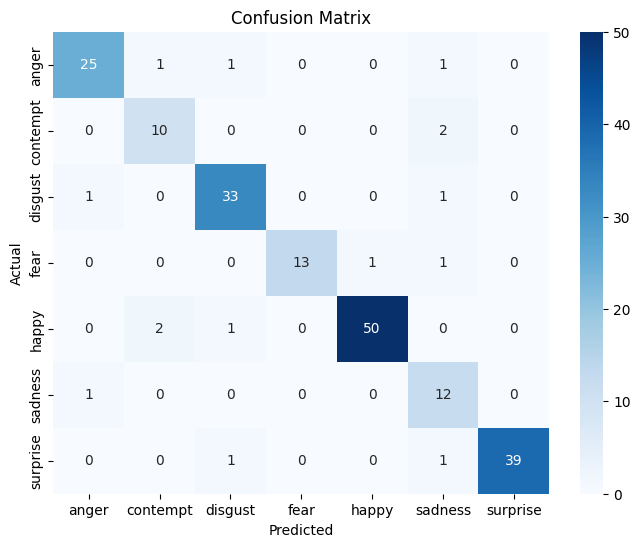

Classification Report:
              precision    recall  f1-score   support

       anger       0.93      0.89      0.91        28
    contempt       0.77      0.83      0.80        12
     disgust       0.92      0.94      0.93        35
        fear       1.00      0.87      0.93        15
       happy       0.98      0.94      0.96        53
     sadness       0.67      0.92      0.77        13
    surprise       1.00      0.95      0.97        41

    accuracy                           0.92       197
   macro avg       0.89      0.91      0.90       197
weighted avg       0.93      0.92      0.93       197

Epoch [49/50], Loss: 0.1698
Test Accuracy: 91.88%


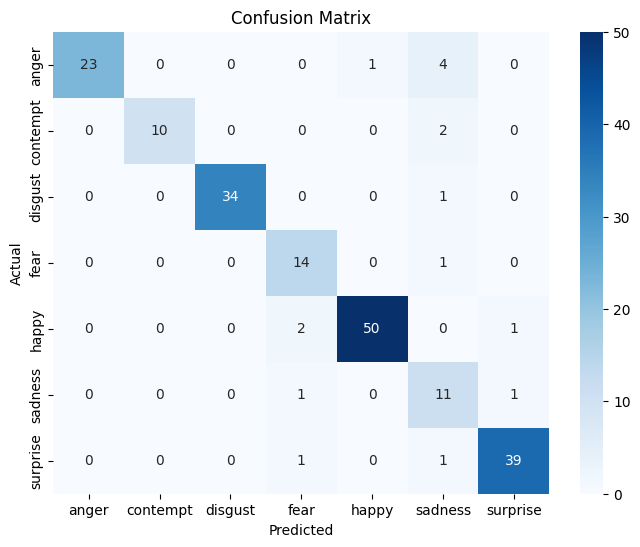

Classification Report:
              precision    recall  f1-score   support

       anger       1.00      0.82      0.90        28
    contempt       1.00      0.83      0.91        12
     disgust       1.00      0.97      0.99        35
        fear       0.78      0.93      0.85        15
       happy       0.98      0.94      0.96        53
     sadness       0.55      0.85      0.67        13
    surprise       0.95      0.95      0.95        41

    accuracy                           0.92       197
   macro avg       0.89      0.90      0.89       197
weighted avg       0.94      0.92      0.92       197

Epoch [50/50], Loss: 0.1706
Test Accuracy: 88.32%


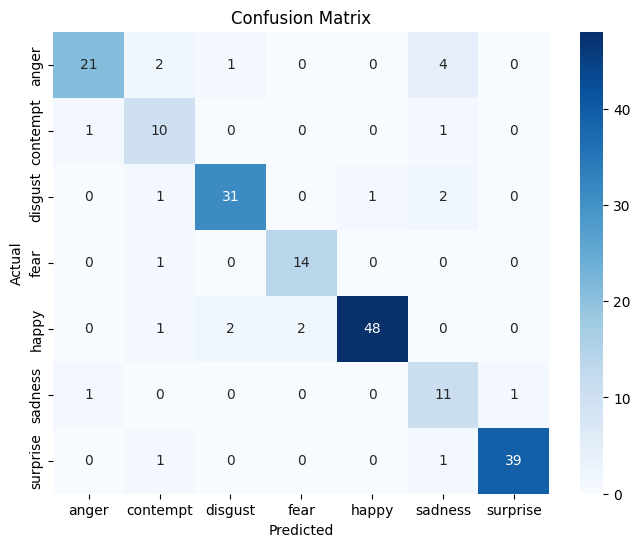

Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.75      0.82        28
    contempt       0.62      0.83      0.71        12
     disgust       0.91      0.89      0.90        35
        fear       0.88      0.93      0.90        15
       happy       0.98      0.91      0.94        53
     sadness       0.58      0.85      0.69        13
    surprise       0.97      0.95      0.96        41

    accuracy                           0.88       197
   macro avg       0.84      0.87      0.85       197
weighted avg       0.90      0.88      0.89       197

Test Accuracy: 92.39%


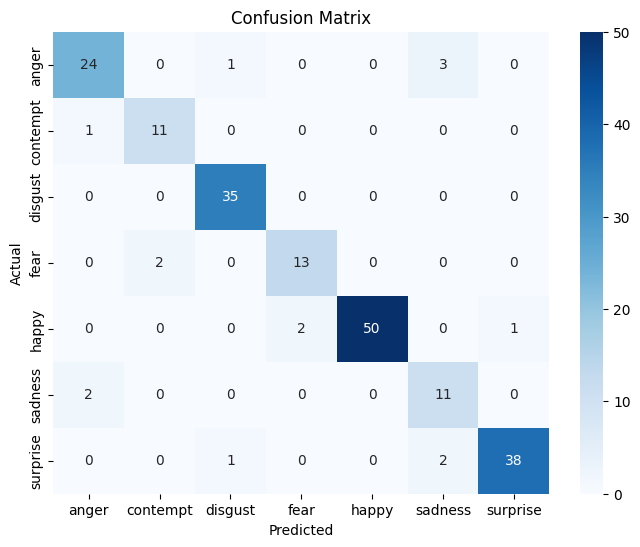

Classification Report:
              precision    recall  f1-score   support

       anger       0.89      0.86      0.87        28
    contempt       0.85      0.92      0.88        12
     disgust       0.95      1.00      0.97        35
        fear       0.87      0.87      0.87        15
       happy       1.00      0.94      0.97        53
     sadness       0.69      0.85      0.76        13
    surprise       0.97      0.93      0.95        41

    accuracy                           0.92       197
   macro avg       0.89      0.91      0.90       197
weighted avg       0.93      0.92      0.93       197



92.38578680203045

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set number of CPU threads for performance
torch.set_num_threads(16)  # Adjust based on CPU cores

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Data Preprocessing for CK+ Dataset
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CK+ Dataset
dataset_path = "/content/newdataset"  # Change to your dataset path
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Check Class Distribution
labels = [label for _, label in full_dataset.samples]
class_counts = Counter(labels)
print("Class distribution:", class_counts)

# Compute Class Weights for Imbalanced Data
class_counts_np = np.bincount(labels)
class_weights = 1.0 / torch.tensor(class_counts_np, dtype=torch.float)
class_weights = class_weights.to(device)

# Split dataset into 80% train and 20% test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define Emotion Recognition Model using EfficientNet-B3
from torchvision.models import efficientnet_b3

class EmotionEfficientNet(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionEfficientNet, self).__init__()
        self.efficientnet = efficientnet_b3(weights="IMAGENET1K_V1")
        self.efficientnet.features[0] = nn.Conv2d(1, 40, kernel_size=3, stride=1, padding=1, bias=False)  # Adjust for grayscale
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)  # Adjust output layer

        # Unfreeze last few layers for fine-tuning
        for name, param in self.efficientnet.named_parameters():
            if "features.6" in name or "features.7" in name or "classifier" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        return self.efficientnet(x)

# Initialize Model
model = EmotionEfficientNet(num_classes=len(full_dataset.classes)).to(device)

# Use Weighted Cross-Entropy Loss for Imbalanced Classes
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Loop
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=50):
    model.train()
    best_acc = 0

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()  # Update learning rate
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

        # Evaluate Model After Each Epoch
        acc = evaluate_model(model, test_loader)
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "new2_ckplus_efficientnet_model.pth")
            print("Best Model Saved!")

# Model Evaluation with Confusion Matrix and Classification Report
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Generate Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes, zero_division=1))

    return accuracy

# Run Training and Evaluation
train_model(model, train_loader, criterion, optimizer, scheduler, epochs=50)
evaluate_model(model, test_loader)


Class distribution: Counter({1: 28709, 0: 7178})
Epoch [1/50], Loss: 0.6508
Test Accuracy: 79.72%


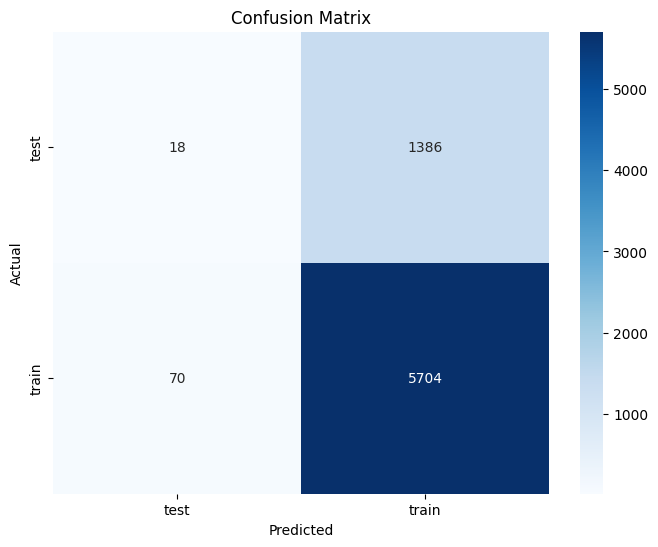

Classification Report:
              precision    recall  f1-score   support

        test       0.20      0.01      0.02      1404
       train       0.80      0.99      0.89      5774

    accuracy                           0.80      7178
   macro avg       0.50      0.50      0.46      7178
weighted avg       0.69      0.80      0.72      7178

Best Model Saved!
Epoch [2/50], Loss: 2.8799
Test Accuracy: 80.47%


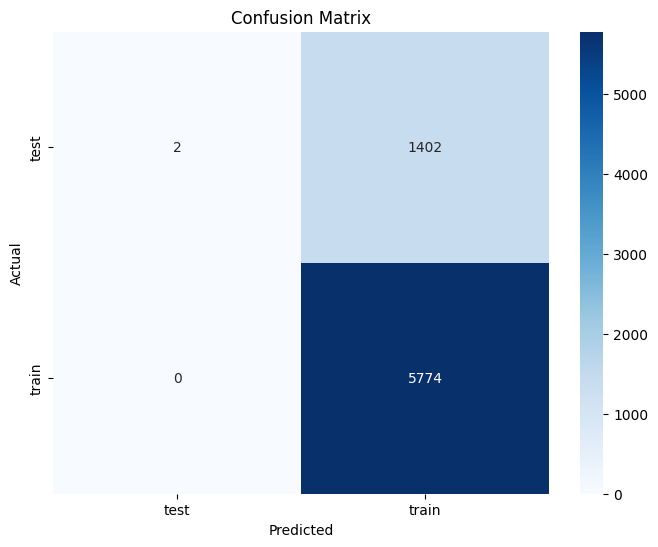

Classification Report:
              precision    recall  f1-score   support

        test       1.00      0.00      0.00      1404
       train       0.80      1.00      0.89      5774

    accuracy                           0.80      7178
   macro avg       0.90      0.50      0.45      7178
weighted avg       0.84      0.80      0.72      7178

Best Model Saved!
Epoch [3/50], Loss: 0.6804
Test Accuracy: 80.44%


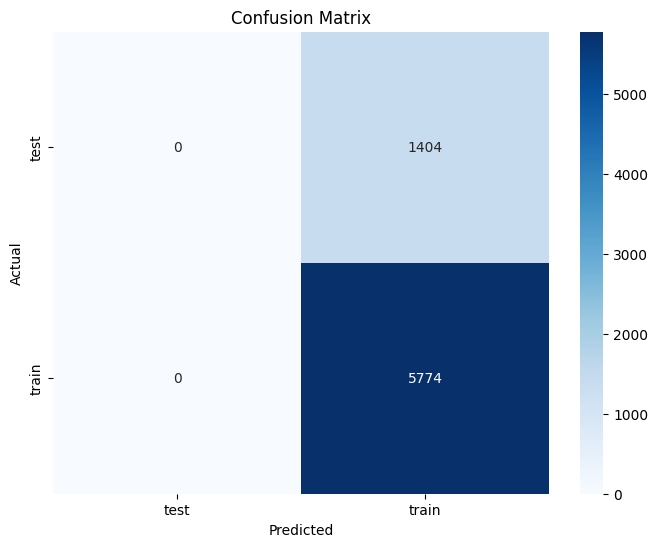

Classification Report:
              precision    recall  f1-score   support

        test       1.00      0.00      0.00      1404
       train       0.80      1.00      0.89      5774

    accuracy                           0.80      7178
   macro avg       0.90      0.50      0.45      7178
weighted avg       0.84      0.80      0.72      7178

Epoch [4/50], Loss: 0.6708
Test Accuracy: 80.33%


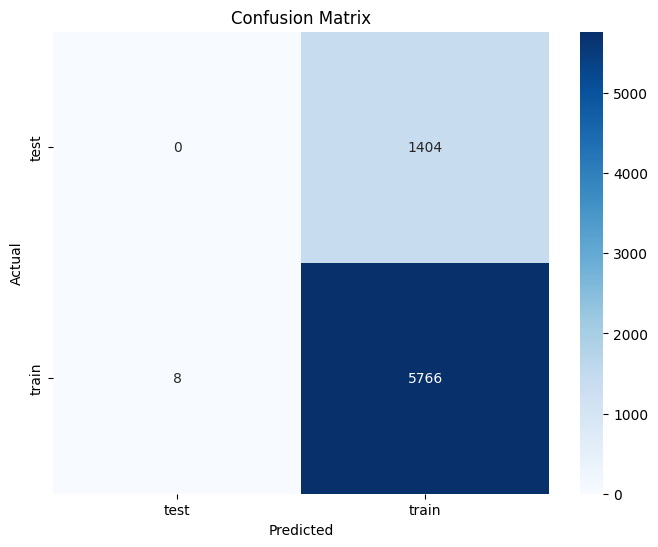

Classification Report:
              precision    recall  f1-score   support

        test       0.00      0.00      0.00      1404
       train       0.80      1.00      0.89      5774

    accuracy                           0.80      7178
   macro avg       0.40      0.50      0.45      7178
weighted avg       0.65      0.80      0.72      7178

Epoch [5/50], Loss: 0.6464
Test Accuracy: 80.12%


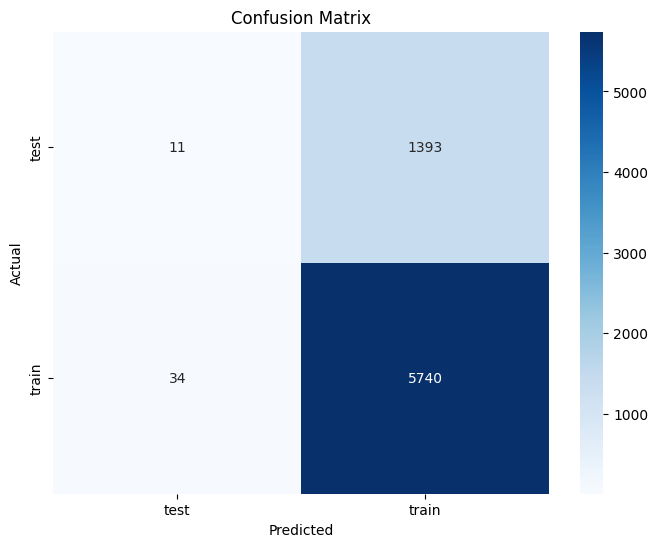

Classification Report:
              precision    recall  f1-score   support

        test       0.24      0.01      0.02      1404
       train       0.80      0.99      0.89      5774

    accuracy                           0.80      7178
   macro avg       0.52      0.50      0.45      7178
weighted avg       0.70      0.80      0.72      7178



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

# Set number of CPU threads for performance
torch.set_num_threads(16)  # Adjust based on CPU cores

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Data Preprocessing for CK+ Dataset
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CK+ Dataset
dataset_path = "/content/dataset"  # Change to your dataset path
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Check Class Distribution
labels = [label for _, label in full_dataset.samples]
class_counts = Counter(labels)
print("Class distribution:", class_counts)

# Compute Class Weights for Imbalanced Data
class_counts_np = np.bincount(labels)
class_weights = 1.0 / torch.sqrt(torch.tensor(class_counts_np, dtype=torch.float))
class_weights = class_weights.to(device)

# Split dataset into 80% train and 20% test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define Emotion Recognition Model using EfficientNet-B3
from torchvision.models import efficientnet_b3

class EmotionEfficientNet(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionEfficientNet, self).__init__()
        self.efficientnet = efficientnet_b3(weights="IMAGENET1K_V1")
        self.efficientnet.features[0] = nn.Conv2d(1, 40, kernel_size=3, stride=1, padding=1, bias=False)  # Adjust for grayscale
        self.efficientnet.classifier[1] = nn.Linear(self.efficientnet.classifier[1].in_features, num_classes)  # Adjust output layer

        # Unfreeze last few layers for fine-tuning
        for name, param in self.efficientnet.named_parameters():
            if "features.6" in name or "features.7" in name or "classifier" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        return self.efficientnet(x)

# Initialize Model
model = EmotionEfficientNet(num_classes=len(full_dataset.classes)).to(device)

# Use Weighted Cross-Entropy Loss for Imbalanced Classes
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training Loop with Test-Time Augmentation (TTA)
def tta_predict(model, image, n=5):
    model.eval()
    preds = []
    for _ in range(n):
        transformed_image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(transformed_image)
            preds.append(torch.softmax(output, dim=1).cpu().numpy())
    return np.mean(preds, axis=0)

def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=50):
    model.train()
    best_acc = 0

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()  # Update learning rate
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

        # Evaluate Model After Each Epoch
        acc = evaluate_model(model, test_loader)
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "new3_ckplus_efficientnet_model.pth")
            print("Best Model Saved!")

# Model Evaluation with Confusion Matrix and Classification Report
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Generate Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes, zero_division=1))

    return accuracy

# Run Training and Evaluation
train_model(model, train_loader, criterion, optimizer, scheduler, epochs=50)
evaluate_model(model, test_loader)


In [ ]:
!ls /content


sample_data


In [ ]:
!ls /content


sample_data
